In [1]:
# !pip install xlrd
# !pip install imbalanced-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
from datetime import datetime
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [3]:
def list_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            print(os.path.join(root, file))

folder_path = "Datasets"
list_files(folder_path)

Datasets\CreditRiskClassification\customer_data.csv
Datasets\CreditRiskClassification\payment_data.csv
Datasets\GermanCreditRisk\german_credit_data.csv
Datasets\GiveMeSomeCredit\cs-test.csv
Datasets\GiveMeSomeCredit\cs-training.csv
Datasets\OriginalDataset\CleanedOriginalDataset.csv


In [4]:
def load_datasets(directory):
    datasets = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if file.endswith('.csv'):
                datasets[file] = pd.read_csv(file_path)
            elif file.endswith('.xlsx'):
                datasets[file] = pd.read_excel(file_path)
            elif file.endswith('.xls'):
                datasets[file] = pd.read_excel(file_path)
            else:
                print(f"Unsupported file format: {file}")
    
    # Check if both required datasets are loaded
    if 'customer_data.csv' in datasets and 'payment_data.csv' in datasets:
        # Check if 'customer_id' column exists in both datasets
        if 'id' in datasets['customer_data.csv'] and 'id' in datasets['payment_data.csv']:
            # Merge datasets on 'customer_id' column
            merged_data = pd.merge(datasets['customer_data.csv'], datasets['payment_data.csv'], on='id', how='inner')
            datasets['merged_payment_customer_data.csv'] = merged_data
        else:
            print("Error: 'customer_id' column not found in one or both datasets.")
    else:
        print("Error: Required datasets 'customer_data.csv' and/or 'payment_data.csv' not found.")

    return datasets

def describe_datasets(datasets):
    for file, data in datasets.items():
        print(f"Dataset: {file}")
        print(f"Shape: {data.shape}")
        print(f"Columns: {data.columns.tolist()}")
        print(f"Data types:\n{data.dtypes}")
        print(f"Head:\n{data.head()}\n")

def rename_columns(dataset):
    # Find the index of the 'TARGET' column
    target_index = dataset.columns.get_loc('TARGET')
    
    # Rename all columns except the 'TARGET' column
    new_columns = list(dataset.columns)
    for i in range(len(new_columns)):
        if i != target_index:
            new_columns[i] = f"x{i}"
    
    dataset.columns = new_columns
    return dataset


def plot_variable_distribution(dataset):
    for column in dataset.columns:
        if dataset[column].dtype == 'object':  # Categorical variable
            plt.figure(figsize=(10, 6))
            sns.countplot(x=column, data=dataset, palette='viridis')
            plt.title(f"Distribution of {column} in {dataset_name}")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.show()
        else:  # Numeric variable
            plt.figure(figsize=(10, 6))
            sns.histplot(dataset[column], kde=True, color='blue', bins=30)
            plt.title(f"Distribution of {column} in {dataset_name}")
            plt.xlabel(column)
            plt.ylabel("Frequency")
            plt.show()

def plot_outliers(dataset):
    for column in dataset.columns:
        if dataset[column].dtype != 'object':  # Exclude object (string) columns
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=dataset[column], color='blue')
            plt.title(f"Outliers in {column} in {dataset_name}")
            plt.xlabel(column)
            plt.show()



# Function to remove outliers in a dataset
def remove_outliers(dataset, lower_quantile=0.05, upper_quantile=0.95):
    for column in dataset.columns:
        if dataset[column].dtype != 'object':  # Exclude object (string) columns
            lower_bound = dataset[column].quantile(lower_quantile)
            upper_bound = dataset[column].quantile(upper_quantile)
            dataset[column] = dataset[column].clip(lower_bound, upper_bound)
    return dataset

# Function to treat missing values in a dataset
def treat_missing_values(dataset):
    for column in dataset.columns:
        if dataset[column].dtype != 'object':  # Numerical column
            dataset[column] = dataset[column].fillna(dataset[column].mean())
        else:  # Categorical column
            dataset[column] = dataset[column].fillna(dataset[column].mode()[0])
    return dataset

def plot_confusion_matrix(cm, classes, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def identify_high_missing_cols(data, threshold=50):

    # Calculate percentage of missing values in each column
    missing_percentages = (data.isnull().sum() / len(data)) * 100

    # Identify columns with too many missing values
    high_missing_cols = missing_percentages[missing_percentages > threshold].index.tolist()

    return high_missing_cols

def preprocess_data(data, target_column):
    # Calculate percentage of missing values in each column
    missing_percentages = (data.isnull().sum() / len(data)) * 100

    # Separate features and target
    features = data.drop(columns=[target_column])
    target = data[target_column]

    # Identify columns with too many missing values (e.g., > 50%)
    high_missing_cols = missing_percentages[missing_percentages > 50].index.tolist()
    print("Columns with too many missing values (> 50%):\n", high_missing_cols)

    # Remove columns with too many missing values
    features_cleaned = features.drop(columns=high_missing_cols)

    # Separate numerical, categorical, and date columns
    numerical_cols = features_cleaned.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = features_cleaned.select_dtypes(include=['object']).columns

    # Preprocess numerical features
    for col in numerical_cols:
        imputer = SimpleImputer(strategy='median')
        features_cleaned[col] = imputer.fit_transform(features_cleaned[[col]]).ravel()  # Flatten the result
        scaler = StandardScaler()
        features_cleaned[col] = scaler.fit_transform(features_cleaned[[col]]).ravel()  # Flatten the result

    # Preprocess categorical features
    for col in categorical_cols:
        imputer = SimpleImputer(strategy='most_frequent')
        features_cleaned[col] = imputer.fit_transform(features_cleaned[[col]]).ravel()  # Flatten the result
        top_categories = features_cleaned[col].value_counts().index[:10]  # Select top 10 frequent categories
        for category in top_categories:
            features_cleaned[col + '_' + str(category)] = (features_cleaned[col] == category).astype(int)
        features_cleaned.drop(columns=[col], inplace=True)

    # Preprocess date features if they exist
    date_cols = ['update_date', 'report_date']
    for col in date_cols:
        if col in features_cleaned:
            features_cleaned[col] = pd.to_datetime(features_cleaned[col])  # Convert string to datetime
            features_cleaned[col + '_year'] = features_cleaned[col].dt.year
            features_cleaned[col + '_month'] = features_cleaned[col].dt.month
            features_cleaned[col + '_day'] = features_cleaned[col].dt.day
            features_cleaned.drop(columns=[col], inplace=True)

    # Combine the processed features and target into a DataFrame
    processed_df = pd.concat([features_cleaned, target], axis=1)
    
    return processed_df

def oversample_data(X, y):
    """
    Oversample the minority class in the dataset.
    
    Args:
    - X: Features.
    - y: Target labels.
    
    Returns:
    - X_resampled_over: Oversampled features.
    - y_resampled_over: Oversampled target labels.
    """
    oversampler = RandomOverSampler(random_state=42)
    X_resampled_over, y_resampled_over = oversampler.fit_resample(X, y)
    return X_resampled_over, y_resampled_over

def undersample_data(X, y):
    """
    Undersample the majority class in the dataset.
    
    Args:
    - X: Features.
    - y: Target labels.
    
    Returns:
    - X_resampled_under: Undersampled features.
    - y_resampled_under: Undersampled target labels.
    """
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled_under, y_resampled_under = undersampler.fit_resample(X, y)
    return X_resampled_under, y_resampled_under

def evaluate_model_and_plot(model, X_test, y_test, X_train=None, y_train=None, 
                            plot_learning_curve=False, dataset_name=None, model_name=None, results_df=None):
    """
    Evaluate a trained model, plot evaluation results, and save them to a CSV file if model_name and dataset_name are provided.
    
    Args:
    - model: The trained model object.
    - X_test: Test features.
    - y_test: True labels for the test set.
    - X_train: Training features (optional).
    - y_train: True labels for the training set (optional).
    - plot_learning_curve: Whether to plot learning curves (default: False).
    - dataset_name: Name of the dataset (required if plot_learning_curve=True and model_name is provided).
    - model_name: Name of the model (required if dataset_name is provided).
    - results_df: DataFrame to store evaluation results (optional).
    
    Returns:
    - None
    """
    # Create a new DataFrame if results_df is None
    if results_df is None:
        results_df = pd.DataFrame(columns=[
            'Timestamp', 'Dataset_Name', 'Model_Name', 
            'Accuracy', 'Precision', 'Recall', 'F1_Score', 
            'Confusion_Matrix'
        ])

    # Predicting the target variable using the model on the test set
    y_pred = model.predict(X_test)
    
    # Printing the classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Generating confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotting confusion matrix
    plot_confusion_matrix(cm, classes=np.unique(y_test), dataset_name=dataset_name)
    
    # Calculate evaluation metrics
    roc_auc = roc_auc_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)
    
    # Plot learning curves if requested
    if plot_learning_curve and X_train is not None and y_train is not None:
        # Generating learning curves
        N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5, scoring='f1', train_sizes=np.linspace(0.1,1,10))

        # Creating a figure to plot the mean training and validation scores against the training set sizes
        plt.figure(figsize=(8,5))
        
        # Plotting the training score as a function of the training set size
        plt.plot(N, train_score.mean(axis=1), label='train score')
        
        # Plotting the mean validation score as a function of the training set size
        plt.plot(N, val_score.mean(axis=1), label='validation score')
        
        # Labeling the x-axis as "train size" and the y-axis as "validation mean score"
        plt.xlabel('train size')
        plt.ylabel('validation mean score')
        plt.title('Learning Curves')
        plt.legend()
        plt.show()

    # Save evaluation results to DataFrame
    if isinstance(results_df, pd.DataFrame) and dataset_name and model_name:
        # Get evaluation metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = report['accuracy']
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1_score_v = report['macro avg']['f1-score']

        # Create a new DataFrame for the new row
        new_row = pd.DataFrame({
            'Timestamp': [datetime.now()],
            'Dataset_Name': [dataset_name],
            'Model_Name': [model_name],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1_Score': [f1_score_v],
            'Confusion_Matrix': [cm.tolist()]
        })

        # Concatenate the new row with the existing DataFrame
        results_df = pd.concat([results_df, new_row], ignore_index=True)

        # Save DataFrame to CSV
        csv_file = 'model_evaluation_results.csv'
        if not os.path.isfile(csv_file):
            results_df.to_csv(csv_file, mode='w', index=False)
        else:
            results_df.to_csv(csv_file, mode='a', index=False, header=False)

In [5]:
datasets = load_datasets(folder_path)

In [6]:
describe_datasets(datasets)

Dataset: customer_data.csv
Shape: (1125, 13)
Columns: ['label', 'id', 'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11']
Data types:
label       int64
id          int64
fea_1       int64
fea_2     float64
fea_3       int64
fea_4     float64
fea_5       int64
fea_6       int64
fea_7       int64
fea_8       int64
fea_9       int64
fea_10      int64
fea_11    float64
dtype: object
Head:
   label        id  fea_1   fea_2  fea_3     fea_4  fea_5  fea_6  fea_7  \
0      1  54982665      5  1245.5      3   77000.0      2     15      5   
1      0  59004779      4  1277.0      1  113000.0      2      8     -1   
2      0  58990862      7  1298.0      1  110000.0      2     11     -1   
3      1  58995168      7  1335.5      1  151000.0      2     11      5   
4      0  54987320      7     NaN      2   59000.0      2     11      5   

   fea_8  fea_9  fea_10      fea_11  
0    109      5  151300  244.948974  
1    100      3  341759  207.173840 

In [7]:
# Perform missing data calculation for each dataset
for dataset_name, dataset in datasets.items():
    print(f"Missing values in {dataset_name}:")
    print(dataset.isnull().sum())
    total_missing = dataset.isnull().sum().sum()
    print(f"Total missing values in {dataset_name}: {total_missing}")
    print()

Missing values in customer_data.csv:
label       0
id          0
fea_1       0
fea_2     149
fea_3       0
fea_4       0
fea_5       0
fea_6       0
fea_7       0
fea_8       0
fea_9       0
fea_10      0
fea_11      0
dtype: int64
Total missing values in customer_data.csv: 149

Missing values in payment_data.csv:
id                    0
OVD_t1                0
OVD_t2                0
OVD_t3                0
OVD_sum               0
pay_normal            0
prod_code             0
prod_limit         6118
update_date          26
new_balance           0
highest_balance     409
report_date        1114
dtype: int64
Total missing values in payment_data.csv: 7667

Missing values in german_credit_data.csv:
Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64
Total missing va

In [8]:
for dataset_name, dataset in datasets.items():
    high_missing_cols = identify_high_missing_cols(dataset)
    print("Columns in", dataset_name, " with too many missing values (> 50%):\n", high_missing_cols)

    # Remove columns with too many missing values
    dataset_cleaned = dataset.drop(columns=high_missing_cols)
    
    # Update the dataset in the dictionary
    datasets[dataset_name] = dataset_cleaned

Columns in customer_data.csv  with too many missing values (> 50%):
 []
Columns in payment_data.csv  with too many missing values (> 50%):
 ['prod_limit']
Columns in german_credit_data.csv  with too many missing values (> 50%):
 []
Columns in cs-test.csv  with too many missing values (> 50%):
 ['SeriousDlqin2yrs']
Columns in cs-training.csv  with too many missing values (> 50%):
 []
Columns in CleanedOriginalDataset.csv  with too many missing values (> 50%):
 []
Columns in merged_payment_customer_data.csv  with too many missing values (> 50%):
 ['prod_limit']


Creating Target For Loan.csv

Changing the target of this dataset from "label" to TARGET

In [9]:
for dataset_name, dataset in datasets.items():
  if dataset_name=="merged_payment_customer_data.csv":
    dataset.rename(columns={'label': 'TARGET'}, inplace=True)
    

Changing the target of this dataset from "Risk" to TARGET

In [10]:
for dataset_name, dataset in datasets.items():
  if dataset_name=="german_credit_data.csv":
    dataset.rename(columns={'Risk': 'TARGET'}, inplace=True)
    dataset['TARGET'] = dataset['TARGET'].map({'good': 1, 'bad': 0})

In [11]:
datasets_to_keep = ['german_credit_data.csv', 'merged_payment_customer_data.csv','CleanedOriginalDataset.csv']

# Make a copy of the datasets dictionary and filter out datasets not in the list
filtered_datasets = {key: value for key, value in datasets.items() if key in datasets_to_keep}

print(filtered_datasets)


{'german_credit_data.csv':      Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0             0   67    male    2     own             NaN           little   
1             1   22  female    2     own          little         moderate   
2             2   49    male    1     own          little              NaN   
3             3   45    male    2    free          little           little   
4             4   53    male    2    free          little           little   
..          ...  ...     ...  ...     ...             ...              ...   
995         995   31  female    1     own          little              NaN   
996         996   40    male    3     own          little           little   
997         997   38    male    2     own          little              NaN   
998         998   23    male    2    free          little           little   
999         999   27    male    2     own        moderate         moderate   

     Credit amount  Duration        

In [12]:
# Rename columns for each dataset
for dataset_name, dataset in filtered_datasets.items():
    filtered_datasets[dataset_name] = rename_columns(dataset)

In [13]:
# # Set up the plot
# num_datasets = len(filtered_datasets)
# fig, axes = plt.subplots(num_datasets, 1, figsize=(10, 5*num_datasets))

# # Generate correlation matrices and plot each dataset
# for idx, (dataset_name, dataset) in enumerate(filtered_datasets.items()):
#     ax = axes[idx]
#     try:
#         corr_matrix = dataset.select_dtypes(include=['float64', 'int64']).corr()
#         if not corr_matrix.empty:  # Check if correlation matrix is not empty
#             sns.heatmap(corr_matrix, ax=ax, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={"size": 10})
#             ax.set_title(f"Correlation Matrix for {dataset_name}")
#             ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#             ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
#         else:
#             print(f"Empty correlation matrix for {dataset_name}")
#     except ValueError as e:
#         ax.text(0.5, 0.5, f"Error calculating correlation matrix:\n{e}", 
#                 horizontalalignment='center', verticalalignment='center', fontsize=12, transform=ax.transAxes)

# plt.tight_layout()
# plt.show()

In [14]:
# Treat missing values for each dataset
for dataset_name, dataset in filtered_datasets.items():
    filtered_datasets[dataset_name] = treat_missing_values(dataset)


In [15]:
for dataset_name, dataset in filtered_datasets.items():
    total_missing = dataset.isnull().sum().sum()
    print(f"Total missing values in {dataset_name}: {total_missing}")
    print()

Total missing values in german_credit_data.csv: 0

Total missing values in CleanedOriginalDataset.csv: 0

Total missing values in merged_payment_customer_data.csv: 0



In [16]:
# Plot distribution of variables for each dataset

# pd.set_option('mode.use_inf_as_na', True)
# for dataset_name, dataset in datasets.items():
#    plot_variable_distribution(dataset)

In [17]:
# def find_unique_strings(dataset):
#     unique_strings = {}
#     for column in dataset.columns:
#         if dataset[column].dtype == 'object':  # Check if the column contains strings
#             unique_strings[column] = dataset[column].unique().tolist()
#     return unique_strings

# for dataset_name, dataset in datasets.items():
#     unique_strings = find_unique_strings(dataset)
#     print(f"Unique strings in {dataset_name}:")
#     for column, values in unique_strings.items():
#         print(f"{column}: {values}")
#         print()

In [18]:
# for dataset_name, dataset in filtered_datasets.items():
#     plot_outliers(dataset)    

In [19]:
# Remove outliers for each dataset
for dataset_name, dataset in filtered_datasets.items():
    datasets[dataset_name] = remove_outliers(dataset)

In [20]:
# for dataset_name, dataset in filtered_datasets.items():
#     plot_outliers(dataset)

# DATA PREPROCESSING

In [21]:
processed_datasets = {}

for dataset_name, dataset in filtered_datasets.items():
    processed_data = preprocess_data(dataset, 'TARGET')
    processed_datasets[dataset_name] = processed_data

Columns with too many missing values (> 50%):
 []
Columns with too many missing values (> 50%):
 []
Columns with too many missing values (> 50%):
 []


In [22]:
import scorecardpy as sc
import pandas as pd

top_features_count = 8
new_datasets = {}

for dataset_name, dataset in processed_datasets.items():
    # Step 1: Perform WoE binning
    bins = sc.woebin(dataset, y="TARGET")
    
    # Step 2: Convert binned data to DataFrame
    binned_data = sc.woebin_ply(dataset, bins)
    
    # Get the original column names before WoE transformation
    original_column_names = list(dataset.columns)
    
    # Step 3: Perform IV calculation on the binned data
    selected_features = sc.iv(binned_data, y="TARGET")
    
    # Print or store the selected features for the current dataset
    print(f"Selected features for {dataset_name}:")
    print(selected_features)
    
    # Sort features based on IV scores and select the top features
    selected_features_sorted = selected_features.sort_values(by="info_value", ascending=False)
    top_features = selected_features_sorted.head(top_features_count)
    
    # Extract the top feature names
    top_feature_names = top_features['variable'].tolist()
    
    # Automatically generate the mapping between WoE-transformed column names and original column names
    woe_to_original_mapping = {}
    for woe_column in top_feature_names:
        for original_column in original_column_names:
            if woe_column.startswith(original_column):
                woe_to_original_mapping[woe_column] = original_column
    
    # Map the WoE-transformed feature names to original feature names
    top_feature_names_mapped = [woe_to_original_mapping[col] for col in top_feature_names]
    
    # Select the top features and the target variable from the original dataset using the mapped column names
    new_dataset = dataset[top_feature_names_mapped + ['TARGET']].copy()
    print(new_dataset)
    
    # Store the new dataset in a dictionary
    new_datasets[dataset_name] = new_dataset
    
    # Print or store the selected top features for the current dataset
    print(f"Top {top_features_count} features for {dataset_name}:")
    print(top_features)


[INFO] creating woe binning ...
[INFO] converting into woe values ...
Selected features for german_credit_data.csv:
                      variable  info_value
1                       x8_woe    0.281952
13                      x7_woe    0.180173
9                       x1_woe    0.130499
18                      x0_woe    0.089842
4                   x4_own_woe    0.082951
17             x6_moderate_woe    0.065405
22             x9_radio/TV_woe    0.057796
16                 x4_rent_woe    0.038878
19               x6_little_woe    0.037654
8                  x4_free_woe    0.029570
20           x5_quite rich_woe    0.028059
24                 x2_male_woe    0.026543
14               x2_female_woe    0.026543
12               x5_little_woe    0.024727
3             x9_education_woe    0.010757
23                 x6_rich_woe    0.010039
6                       x3_woe    0.008095
5              x9_business_woe    0.005985
21                  x9_car_woe    0.002421
11             x5_modera

In [23]:
for dataset_name, dataset in new_datasets.items():
  print(dataset)

           x8        x7        x1        x0  x4_own  x6_moderate  x9_radio/TV  \
0   -1.282046 -0.833261  2.315223 -1.579953       1            0            1   
1    2.374972  1.192255 -1.252870 -1.579953       1            1            1   
2   -0.759615 -0.440611  1.282354 -1.579953       1            0            0   
3    1.852541  2.010170  0.906765 -1.579953       0            0            0   
4    0.285247  0.734375  1.657943 -1.579953       0            0            0   
..        ...       ...       ...       ...     ...          ...          ...   
995 -0.759615 -0.593096 -0.407795  1.579953       1            0            0   
996  0.807679  0.305297  0.437279  1.579953       1            0            0   
997 -0.759615 -0.987864  0.249485  1.579953       1            0            1   
998  2.113757 -0.546927 -1.158973  1.579953       0            0            1   
999  2.113757  0.609845 -0.783384  1.579953       1            1            0   

     x4_rent  TARGET  
0   

# Modeling

In [24]:
for dataset_name, dataset in new_datasets.items():
  target_counts = dataset['TARGET'].value_counts()

  # Print the counts
  print("Counts of each unique value in the 'TARGET' column for {dataset_name}:")
  print(target_counts)

Counts of each unique value in the 'TARGET' column for {dataset_name}:
TARGET
1    700
0    300
Name: count, dtype: int64
Counts of each unique value in the 'TARGET' column for {dataset_name}:
TARGET
0    160966
1     17453
Name: count, dtype: int64
Counts of each unique value in the 'TARGET' column for {dataset_name}:
TARGET
0    6863
1    1387
Name: count, dtype: int64


# XGBoost Model

## Normal XGBoost

Evalution for german_credit_data.csv:

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.39      0.46        59
           1       0.77      0.87      0.82       141

    accuracy                           0.73       200
   macro avg       0.66      0.63      0.64       200
weighted avg       0.71      0.72      0.71       200



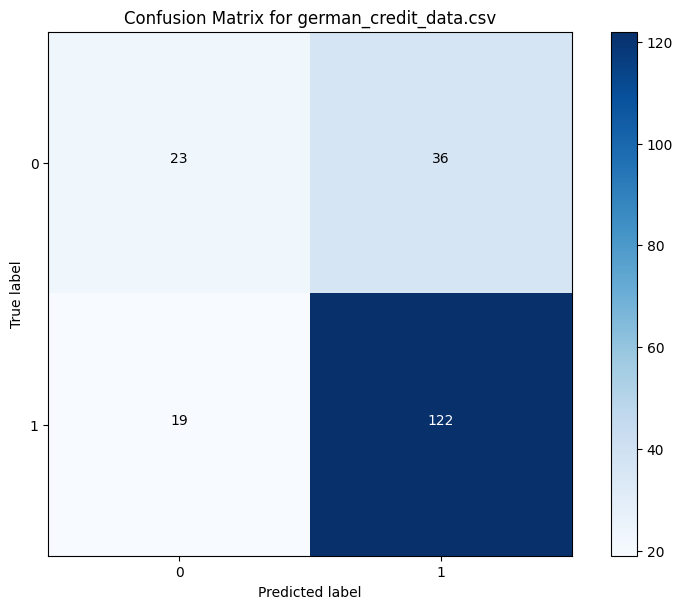

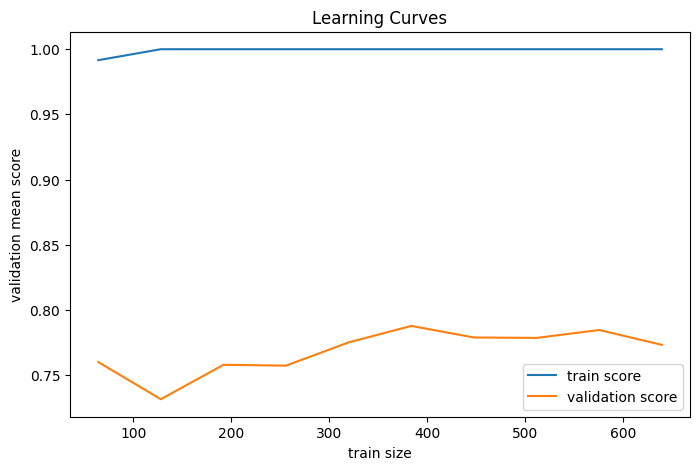

Evalution for CleanedOriginalDataset.csv:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     32199
           1       0.28      0.00      0.01      3485

    accuracy                           0.90     35684
   macro avg       0.59      0.50      0.48     35684
weighted avg       0.84      0.90      0.86     35684



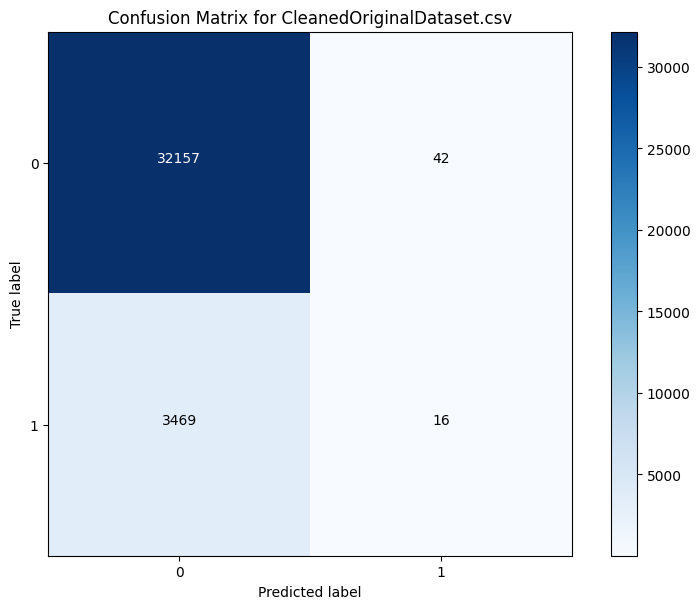

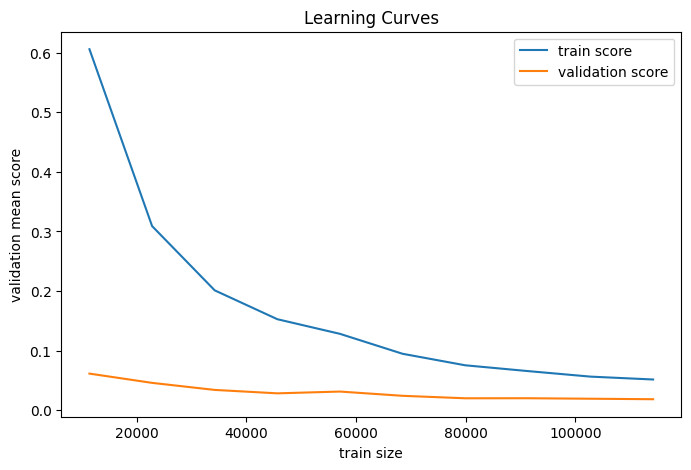

Evalution for merged_payment_customer_data.csv:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1384
           1       0.99      0.99      0.99       266

    accuracy                           1.00      1650
   macro avg       0.99      0.99      0.99      1650
weighted avg       1.00      1.00      1.00      1650



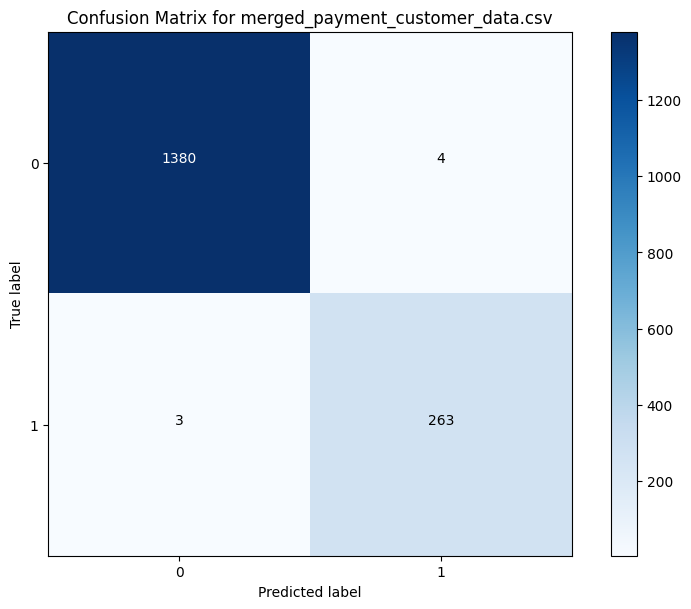

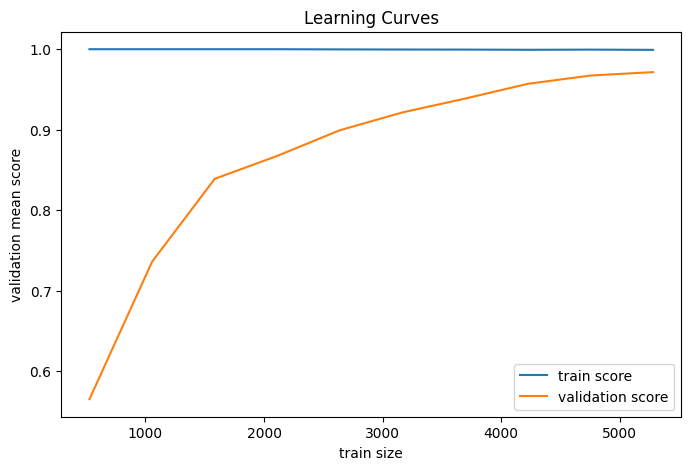

In [25]:
for dataset_name, dataset in new_datasets.items():
    X = dataset.drop(columns=['TARGET'])  # Assuming 'TARGET' is the name of the target column
    y = dataset['TARGET']
    
    modelXGB1 = xgb.XGBClassifier(
        objective='binary:logistic',  # Binary classification
        eval_metric='logloss'  # Metric for evaluation
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    modelXGB1.fit(X_train, y_train)
    
    print(f"Evalution for {dataset_name}:\n")
    evaluate_model_and_plot(modelXGB1, X_test, y_test, X_train, y_train, plot_learning_curve=True, dataset_name=dataset_name, model_name='XGBoost')


## XGBoost on Oversampled and Undersampled data

Shape after oversampling for german_credit_data.csv: (1118, 8)
Frequency of each class after oversampling:
TARGET
0    559
1    559
Name: count, dtype: int64
Shape after undersampling for german_credit_data.csv: (482, 8)
Frequency of each class after undersampling:
TARGET
0    241
1    241
Name: count, dtype: int64
Evaluation Of Oversampling of german_credit_data.csv
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.36      0.40        59
           1       0.75      0.82      0.78       141

    accuracy                           0.68       200
   macro avg       0.60      0.59      0.59       200
weighted avg       0.66      0.68      0.67       200



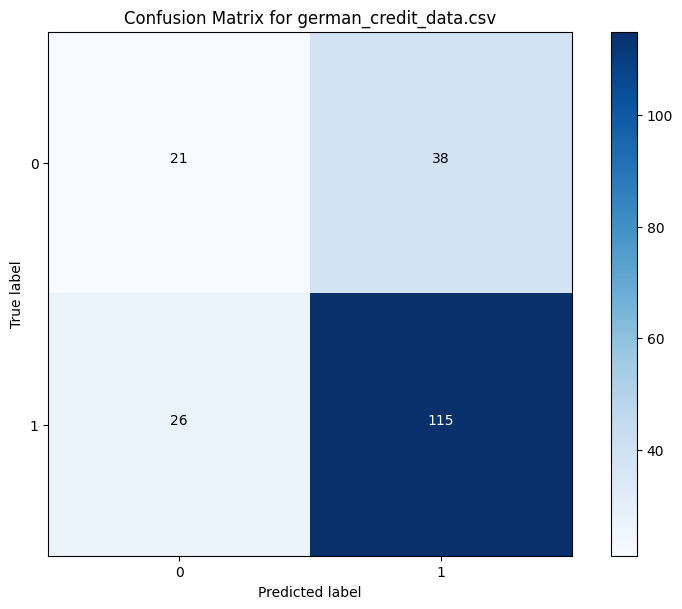

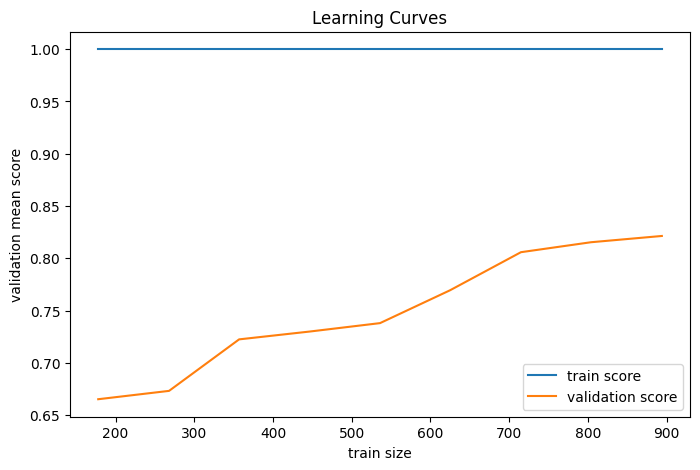


Evaluation Of Undersampling of german_credit_data.csv
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.61      0.49        59
           1       0.79      0.63      0.70       141

    accuracy                           0.62       200
   macro avg       0.60      0.62      0.60       200
weighted avg       0.68      0.62      0.64       200



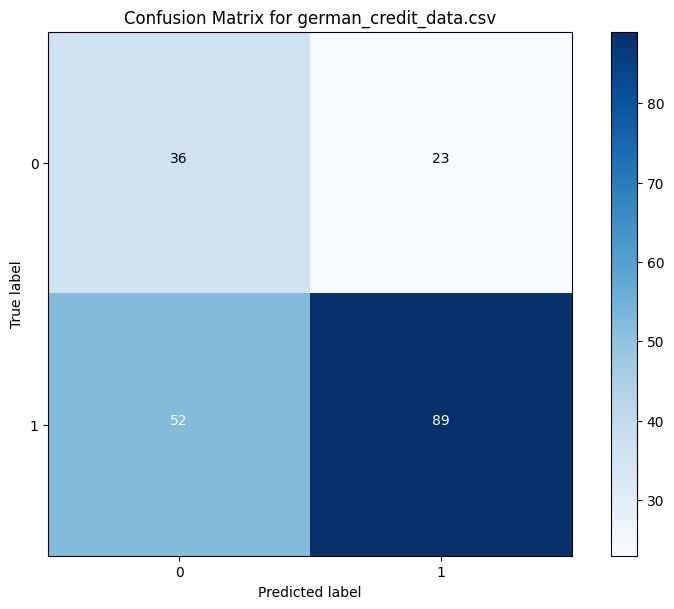

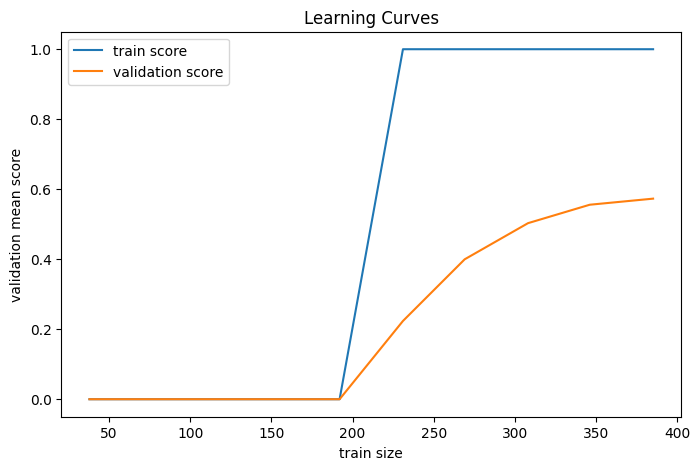

Shape after oversampling for CleanedOriginalDataset.csv: (257534, 8)
Frequency of each class after oversampling:
TARGET
0    128767
1    128767
Name: count, dtype: int64
Shape after undersampling for CleanedOriginalDataset.csv: (27936, 8)
Frequency of each class after undersampling:
TARGET
0    13968
1    13968
Name: count, dtype: int64
Evaluation Of Oversampling of CleanedOriginalDataset.csv
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     32199
           1       0.17      0.56      0.26      3485

    accuracy                           0.69     35684
   macro avg       0.55      0.63      0.53     35684
weighted avg       0.86      0.69      0.75     35684



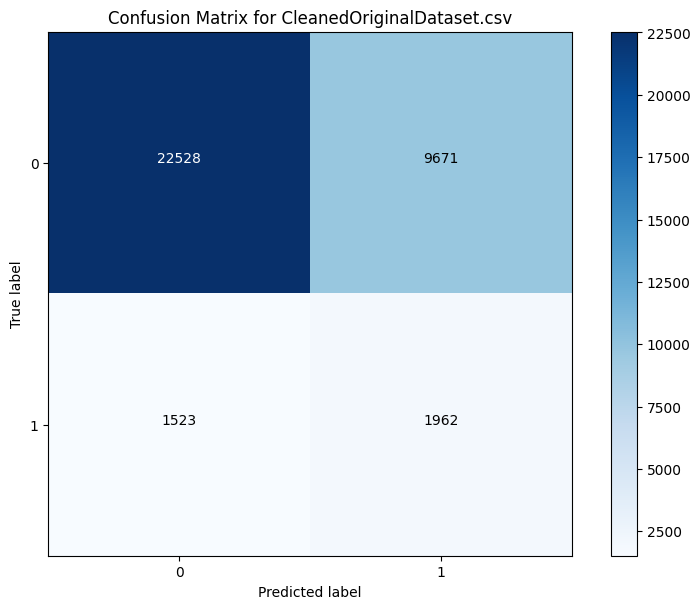

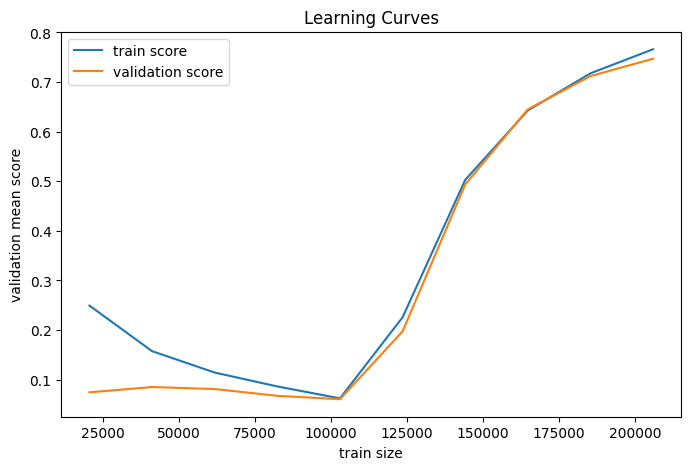


Evaluation Of Undersampling of CleanedOriginalDataset.csv
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.63      0.76     32199
           1       0.16      0.63      0.25      3485

    accuracy                           0.63     35684
   macro avg       0.55      0.63      0.50     35684
weighted avg       0.86      0.63      0.71     35684



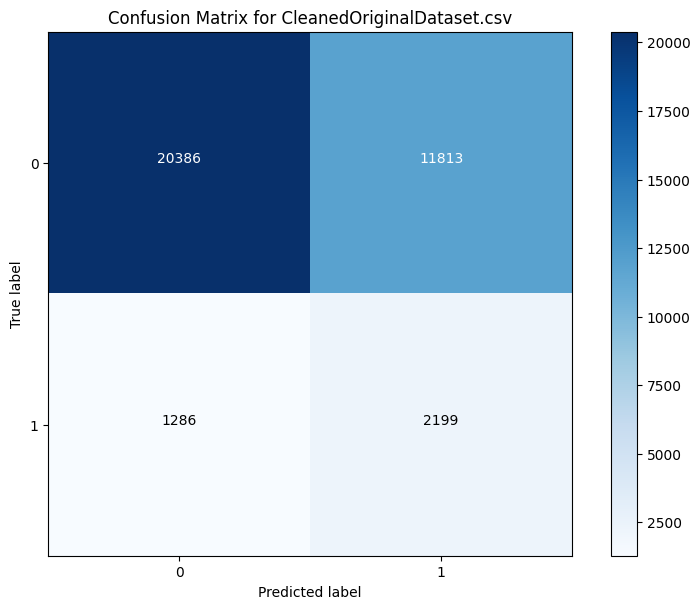

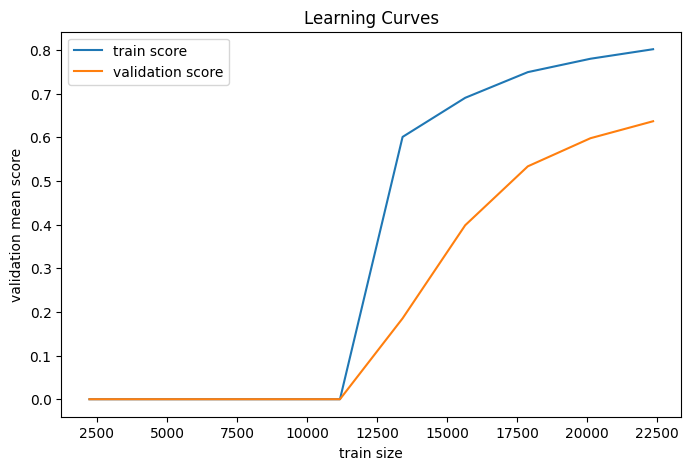

Shape after oversampling for merged_payment_customer_data.csv: (10958, 8)
Frequency of each class after oversampling:
TARGET
0    5479
1    5479
Name: count, dtype: int64
Shape after undersampling for merged_payment_customer_data.csv: (2242, 8)
Frequency of each class after undersampling:
TARGET
0    1121
1    1121
Name: count, dtype: int64
Evaluation Of Oversampling of merged_payment_customer_data.csv
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1384
           1       0.99      0.99      0.99       266

    accuracy                           1.00      1650
   macro avg       0.99      1.00      0.99      1650
weighted avg       1.00      1.00      1.00      1650



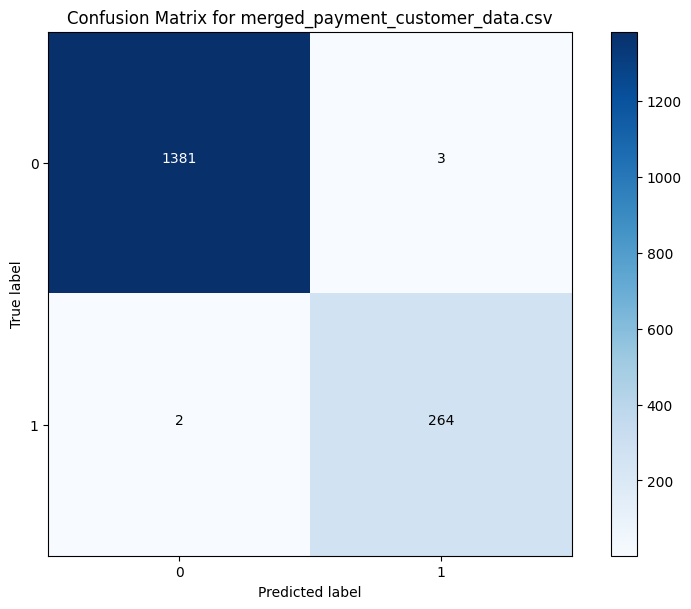

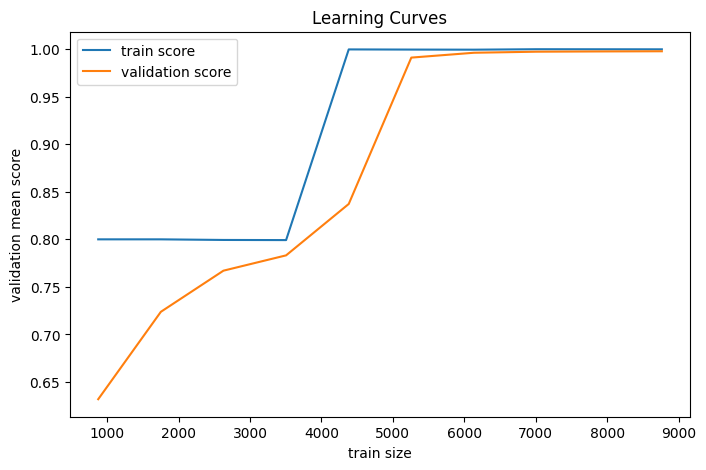


Evaluation Of Undersampling of merged_payment_customer_data.csv
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1384
           1       0.80      1.00      0.89       266

    accuracy                           0.96      1650
   macro avg       0.90      0.97      0.93      1650
weighted avg       0.97      0.96      0.96      1650



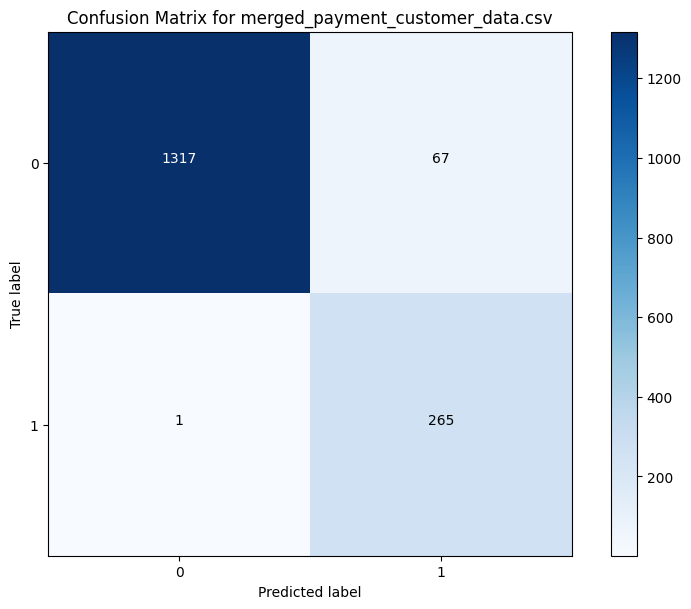

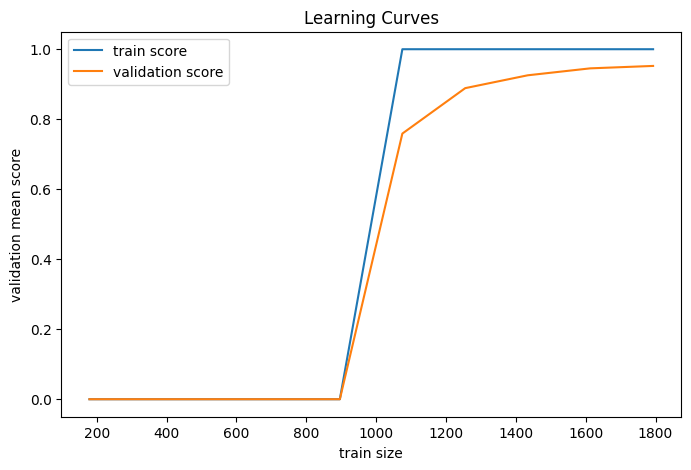

In [26]:
from sklearn.model_selection import train_test_split

for dataset_name, dataset in new_datasets.items():
    X = dataset.drop(columns=['TARGET'])  # Assuming 'TARGET' is the name of the target column
    y = dataset['TARGET']
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    modelXGB2Over = xgb.XGBClassifier(
        objective='binary:logistic',  # Binary classification
        eval_metric='auc'  # Use AUC-ROC for evaluation
    )
    
    modelXGB2Under = xgb.XGBClassifier(
        objective='binary:logistic',  # Binary classification
        eval_metric='auc'  # Use AUC-ROC for evaluation
    )
    
    # Apply oversampling
    X_resampled_over, y_resampled_over = oversample_data(X_train, y_train)
    
    print(f"Shape after oversampling for {dataset_name}: {X_resampled_over.shape}")
    frequencyOver = pd.Series(y_resampled_over).value_counts()
    print("Frequency of each class after oversampling:")
    print(frequencyOver)
    
    # Fit the model before evaluation
    modelXGB2Over.fit(X_resampled_over, y_resampled_over)
    
    # Apply undersampling
    X_resampled_under, y_resampled_under = undersample_data(X_train, y_train)
    
    print(f"Shape after undersampling for {dataset_name}: {X_resampled_under.shape}")
    frequencyUnder = pd.Series(y_resampled_under).value_counts()
    print("Frequency of each class after undersampling:")
    print(frequencyUnder)
    
    # Fit the model before evaluation
    modelXGB2Under.fit(X_resampled_under, y_resampled_under)
    
    print(f"Evaluation Of Oversampling of {dataset_name}")
    evaluate_model_and_plot(modelXGB2Over, X_test, y_test, X_train=X_resampled_over, y_train=y_resampled_over, plot_learning_curve=True, dataset_name=dataset_name, model_name='XGBoost (Oversampling)')
    print()
    print(f"Evaluation Of Undersampling of {dataset_name}")
    evaluate_model_and_plot(modelXGB2Under, X_test, y_test, X_train=X_resampled_under, y_train=y_resampled_under, plot_learning_curve=True, dataset_name=dataset_name, model_name='XGBoost (Undersampling)')


# Logistic Regression Model

## Logistic Regression with cross validation and grid search

Best parameters for german_credit_data.csv: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy score for german_credit_data.csv: 0.7146666666666667
Evalution for german_credit_data.csv :

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.19      0.28        59
           1       0.73      0.94      0.82       141

    accuracy                           0.71       200
   macro avg       0.64      0.56      0.55       200
weighted avg       0.68      0.71      0.66       200



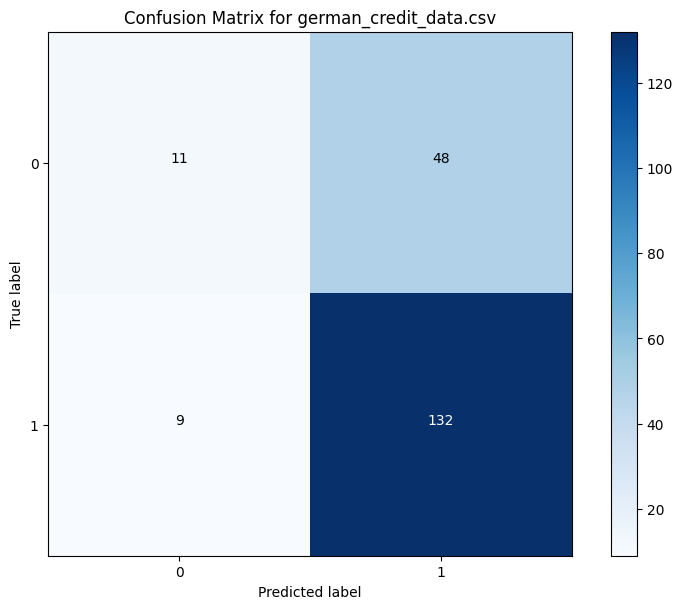

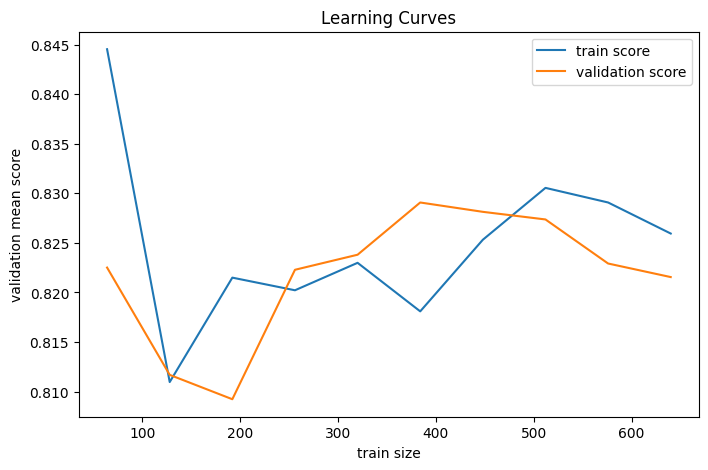

Best parameters for CleanedOriginalDataset.csv: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Best accuracy score for CleanedOriginalDataset.csv: 0.9021797006743764
Evalution for CleanedOriginalDataset.csv :

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     32199
           1       0.00      0.00      0.00      3485

    accuracy                           0.90     35684
   macro avg       0.45      0.50      0.47     35684
weighted avg       0.81      0.90      0.86     35684



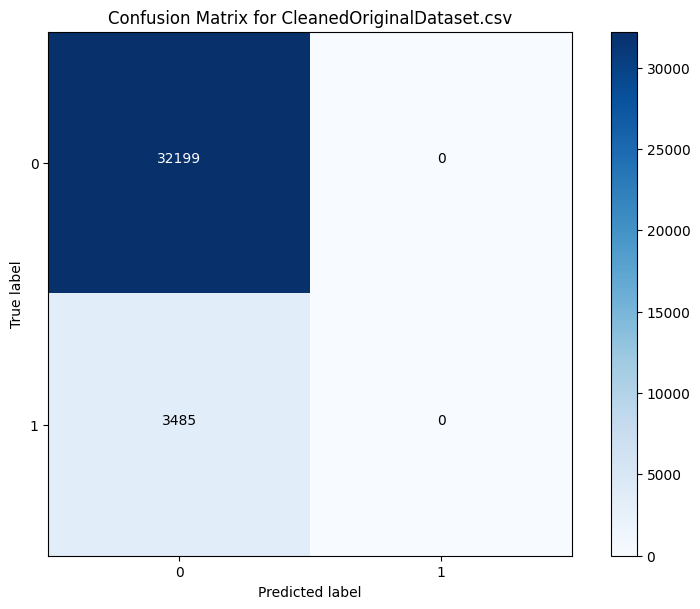

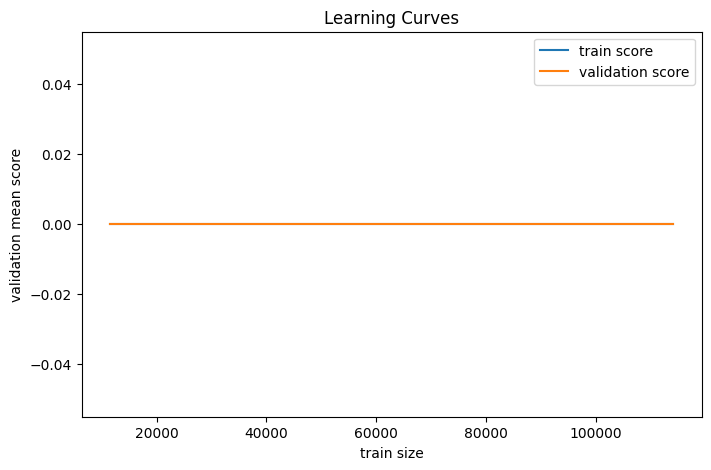

Best parameters for merged_payment_customer_data.csv: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best accuracy score for merged_payment_customer_data.csv: 0.8324848484848485
Evalution for merged_payment_customer_data.csv :

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1384
           1       1.00      0.00      0.01       266

    accuracy                           0.84      1650
   macro avg       0.92      0.50      0.46      1650
weighted avg       0.87      0.84      0.77      1650



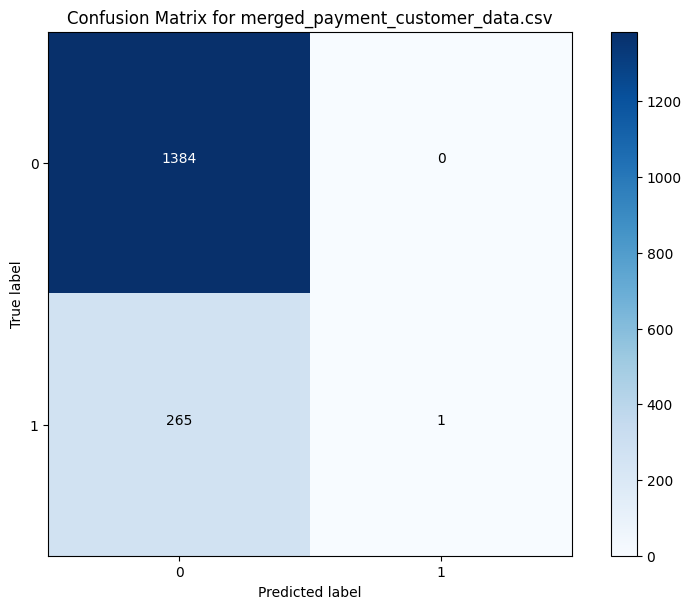

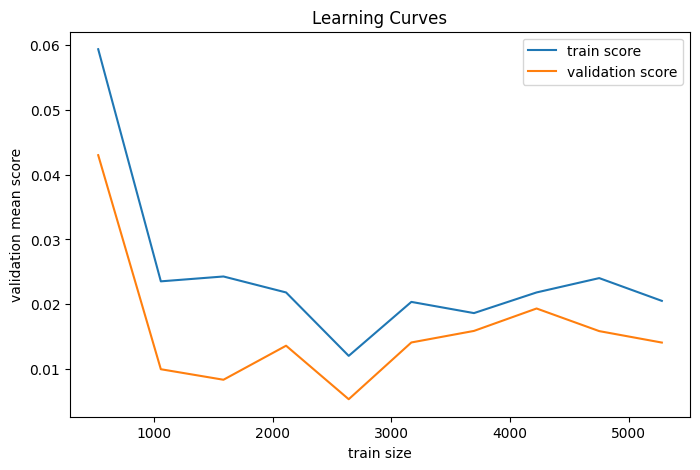

In [27]:
# Define parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['l2']
c_values = [0.01, 0.1, 1, 10, 100]

# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

for dataset_name, dataset in new_datasets.items():
    X = dataset.drop(columns=['TARGET'])  # Assuming 'TARGET' is the name of the target column
    y = dataset['TARGET']

    # Create the logistic regression model
    modelLG1 = LogisticRegression()

    # Create the parameter grid
    param_grid = dict(solver=solvers, penalty=penalty, C=c_values)

    # Define grid search
    grid = GridSearchCV(estimator=modelLG1, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Perform grid search
    grid_result = grid.fit(X, y)

    # Summarize results
    print(f"Best parameters for {dataset_name}: {grid_result.best_params_}")
    print(f"Best accuracy score for {dataset_name}: {grid_result.best_score_}")
    
    print(f"Evalution for {dataset_name} :\n")
    # Apply the evall function
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    evaluate_model_and_plot(grid_result.best_estimator_, X_test, y_test, X_train=X_train, y_train=y_train, 
                            plot_learning_curve=True, dataset_name=dataset_name, model_name='Logistic Regression')


## Logistic Regression with cross validation and grid search on Oversampled and Undersampled data

Shape after oversampling for german_credit_data.csv: (1400, 8)
Shape after undersampling for german_credit_data.csv: (600, 8)
Best parameters after oversampling for german_credit_data.csv: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best accuracy score after oversampling for german_credit_data.csv: 0.6223809523809524
Evalution for german_credit_data.csv using Oversampling :

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.62       131
           1       0.66      0.66      0.66       149

    accuracy                           0.64       280
   macro avg       0.64      0.64      0.64       280
weighted avg       0.64      0.64      0.64       280



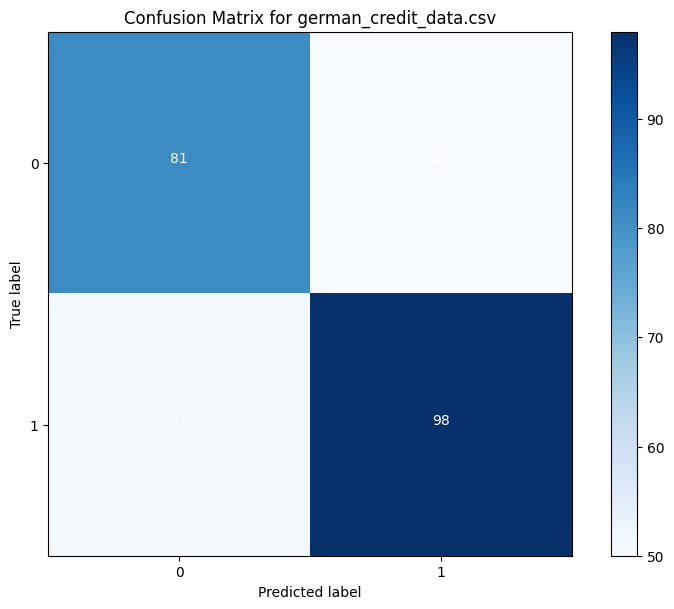

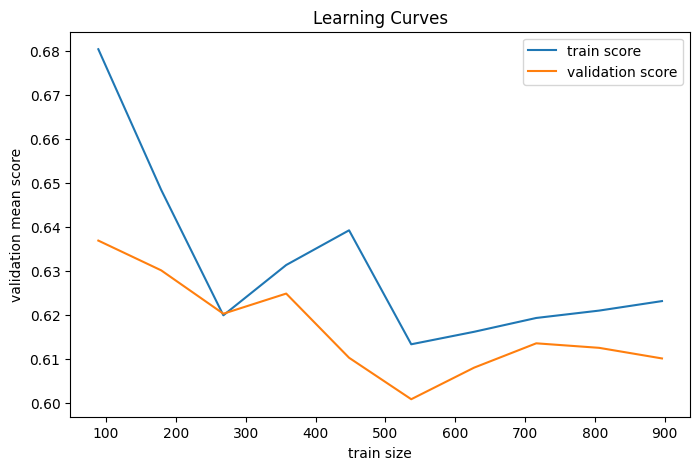

Best parameters after undersampling for german_credit_data.csv: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best accuracy score after undersampling for german_credit_data.csv: 0.6150000000000001
Evalution for german_credit_data.csv using Undersampling :

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64        62
           1       0.62      0.66      0.64        58

    accuracy                           0.64       120
   macro avg       0.64      0.64      0.64       120
weighted avg       0.64      0.64      0.64       120



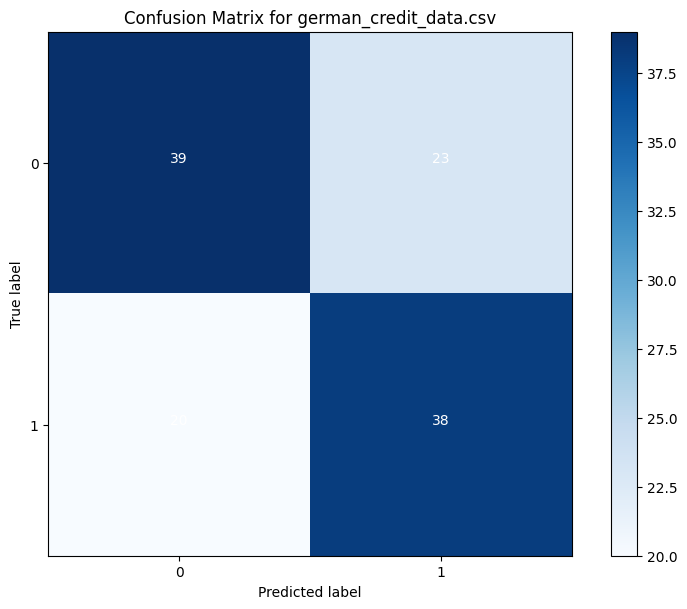

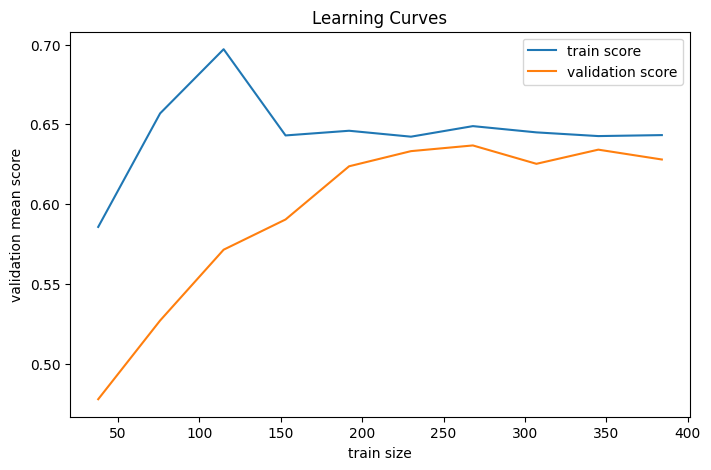

Shape after oversampling for CleanedOriginalDataset.csv: (321932, 8)
Shape after undersampling for CleanedOriginalDataset.csv: (34906, 8)
Best parameters after oversampling for CleanedOriginalDataset.csv: {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
Best accuracy score after oversampling for CleanedOriginalDataset.csv: 0.6453971594263647
Evalution for CleanedOriginalDataset.csv using Oversampling :

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64     32079
           1       0.64      0.67      0.65     32308

    accuracy                           0.65     64387
   macro avg       0.65      0.65      0.65     64387
weighted avg       0.65      0.65      0.65     64387



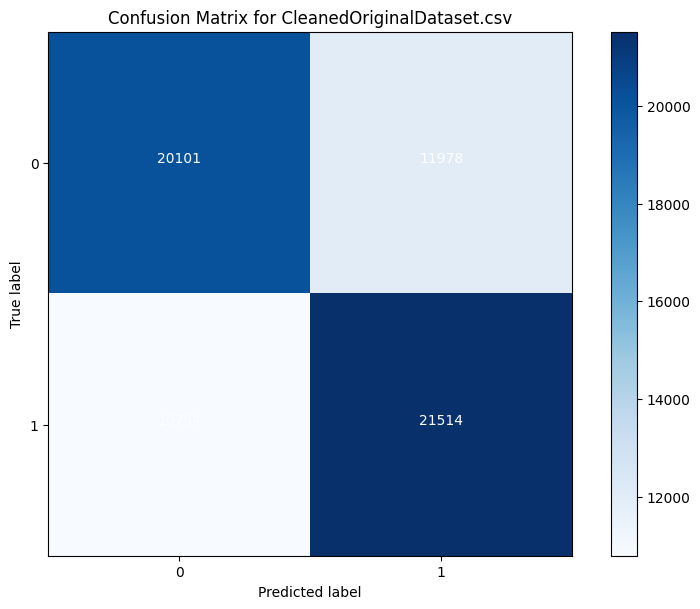

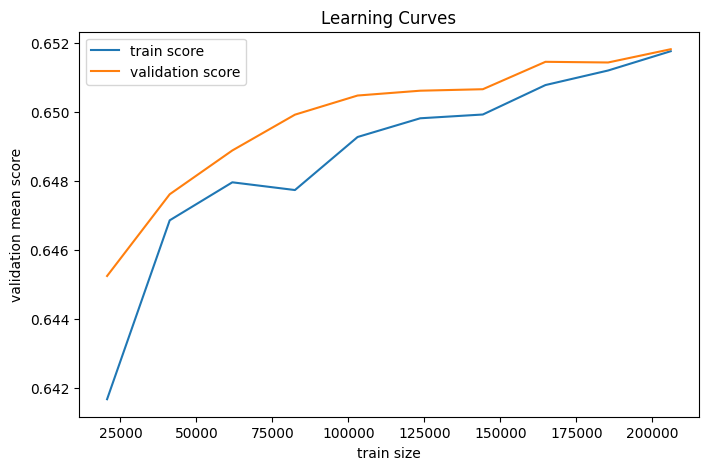

Best parameters after undersampling for CleanedOriginalDataset.csv: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Best accuracy score after undersampling for CleanedOriginalDataset.csv: 0.6453714248026519
Evalution for CleanedOriginalDataset.csv using Undersampling :

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      3478
           1       0.65      0.67      0.66      3504

    accuracy                           0.65      6982
   macro avg       0.65      0.65      0.65      6982
weighted avg       0.65      0.65      0.65      6982



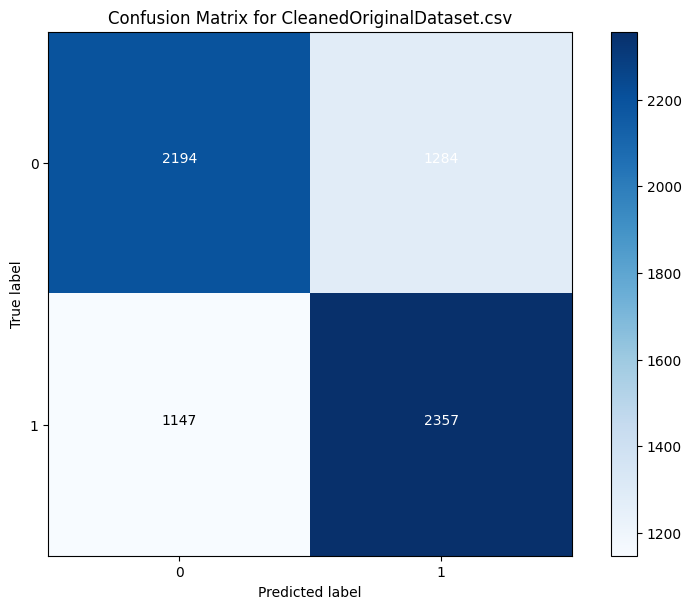

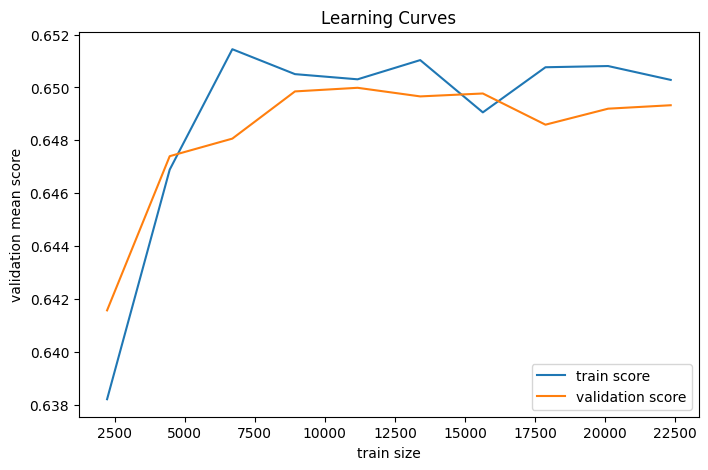

Shape after oversampling for merged_payment_customer_data.csv: (13726, 8)
Shape after undersampling for merged_payment_customer_data.csv: (2774, 8)
Best parameters after oversampling for merged_payment_customer_data.csv: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Best accuracy score after oversampling for merged_payment_customer_data.csv: 0.6128755940638501
Evalution for merged_payment_customer_data.csv using Oversampling :

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.53      0.58      1375
           1       0.59      0.70      0.64      1371

    accuracy                           0.61      2746
   macro avg       0.61      0.61      0.61      2746
weighted avg       0.61      0.61      0.61      2746



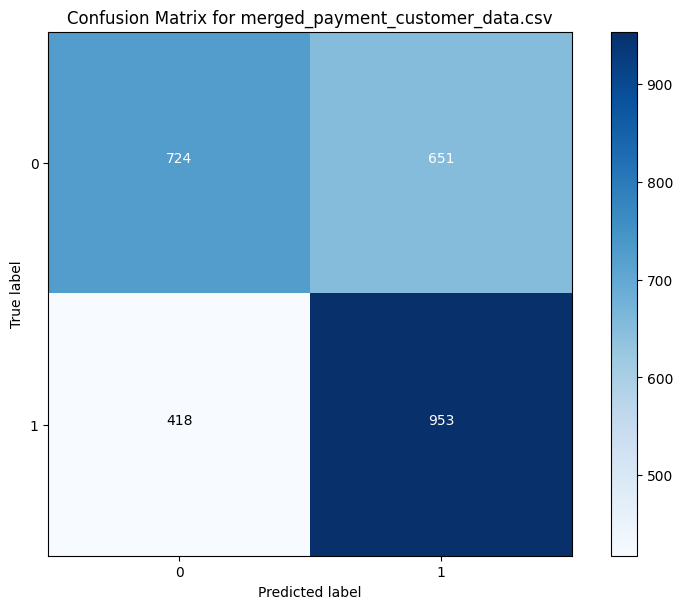

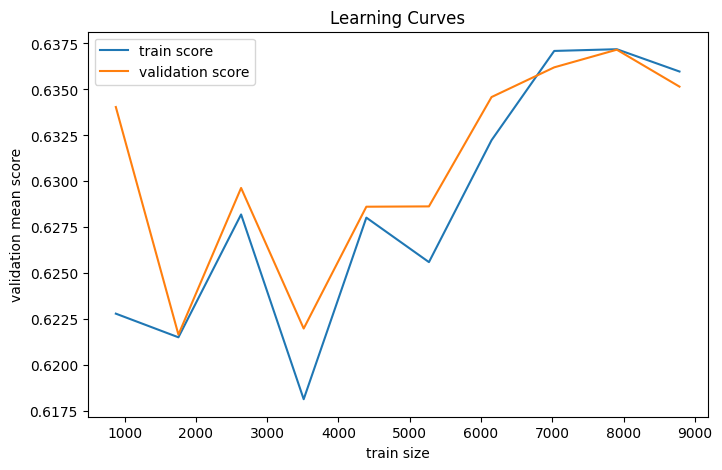

Best parameters after undersampling for merged_payment_customer_data.csv: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Best accuracy score after undersampling for merged_payment_customer_data.csv: 0.6137986361813076
Evalution for merged_payment_customer_data.csv using Undersampling :

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       285
           1       0.60      0.64      0.62       270

    accuracy                           0.62       555
   macro avg       0.62      0.62      0.62       555
weighted avg       0.62      0.62      0.62       555



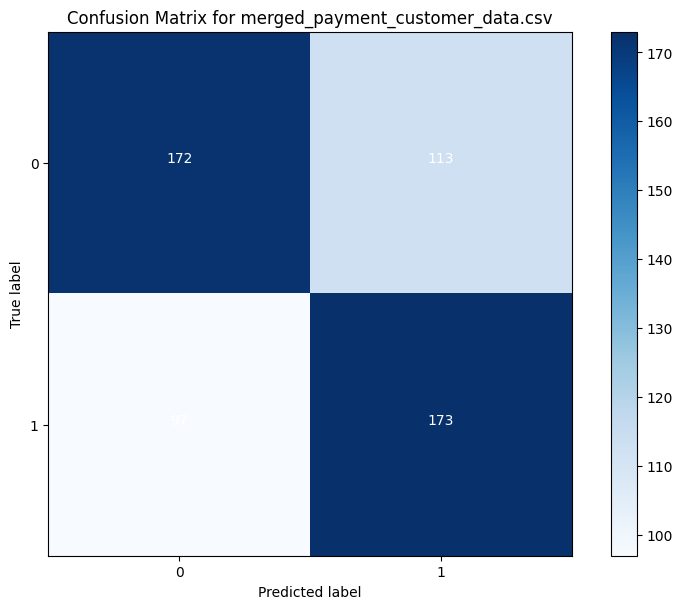

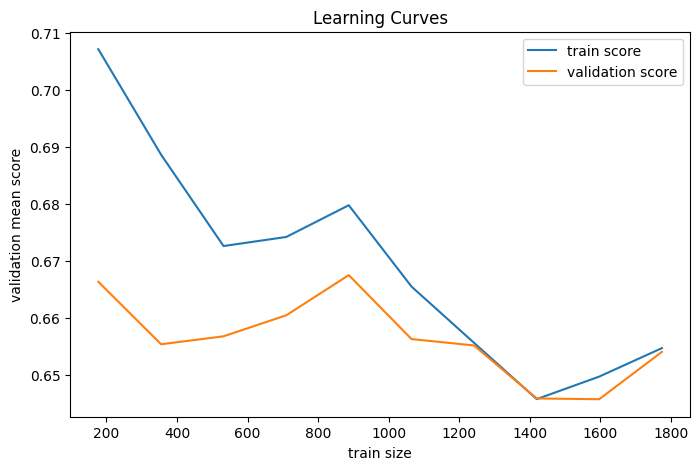

In [28]:
# Define parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
penalty = ['l2']
c_values = [0.01, 0.1, 1, 10, 100]

# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

for dataset_name, dataset in new_datasets.items():
    X = dataset.drop(columns=['TARGET'])  # Assuming 'TARGET' is the name of the target column
    y = dataset['TARGET']

    # Apply oversampling
    X_resampled_over, y_resampled_over = oversample_data(X, y)
    print(f"Shape after oversampling for {dataset_name}: {X_resampled_over.shape}")

    # Apply undersampling
    X_resampled_under, y_resampled_under = undersample_data(X, y)
    print(f"Shape after undersampling for {dataset_name}: {X_resampled_under.shape}")

    # Create the logistic regression model
    modelLG2 = LogisticRegression()

    # Create the parameter grid
    param_grid = dict(solver=solvers, penalty=penalty, C=c_values)

    # Define grid search
    grid = GridSearchCV(estimator=modelLG2, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Perform grid search with oversampled dataset
    grid_result_over = grid.fit(X_resampled_over, y_resampled_over)

    # Summarize results
    print(f"Best parameters after oversampling for {dataset_name}: {grid_result_over.best_params_}")
    print(f"Best accuracy score after oversampling for {dataset_name}: {grid_result_over.best_score_}")

    print(f"Evalution for {dataset_name} using Oversampling :\n")
    # Apply the evaluate_model_and_plot function on the oversampled dataset
    X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_resampled_over, y_resampled_over, test_size=0.2, random_state=42)
    evaluate_model_and_plot(grid_result_over.best_estimator_, X_test_over, y_test_over, X_train=X_train_over, y_train=y_train_over, 
                            plot_learning_curve=True, dataset_name=dataset_name, model_name='Logistic Regression (Oversampling)')

    # Perform grid search with undersampled dataset
    grid_result_under = grid.fit(X_resampled_under, y_resampled_under)

    # Summarize results
    print(f"Best parameters after undersampling for {dataset_name}: {grid_result_under.best_params_}")
    print(f"Best accuracy score after undersampling for {dataset_name}: {grid_result_under.best_score_}")
    
    print(f"Evalution for {dataset_name} using Undersampling :\n")
    # Apply the evaluate_model_and_plot function on the undersampled dataset
    X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_resampled_under, y_resampled_under, test_size=0.2, random_state=42)
    evaluate_model_and_plot(grid_result_under.best_estimator_, X_test_under, y_test_under, X_train=X_train_under, y_train=y_train_under, 
                            plot_learning_curve=True, dataset_name=dataset_name, model_name='Logistic Regression (Undersampling)')


## Normal Logistic Regression with Oversampling and Undersampling

Evalution for german_credit_data.csv using Oversampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       131
           1       0.65      0.63      0.64       149

    accuracy                           0.62       280
   macro avg       0.62      0.62      0.62       280
weighted avg       0.63      0.62      0.63       280



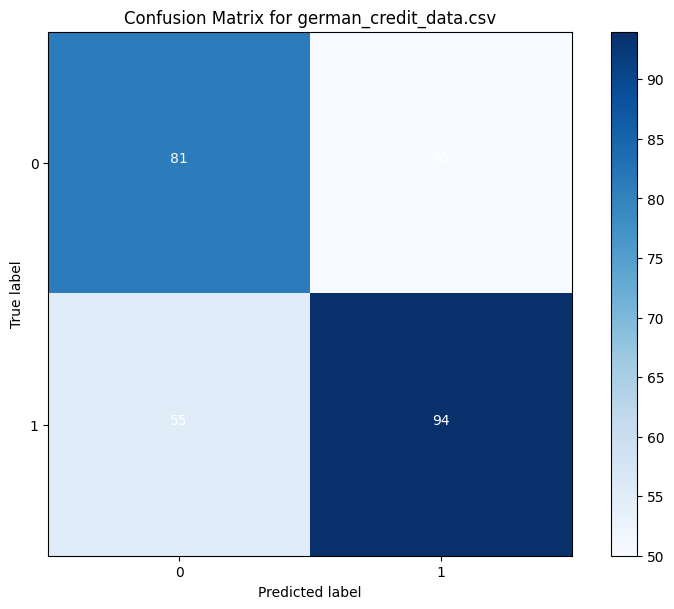

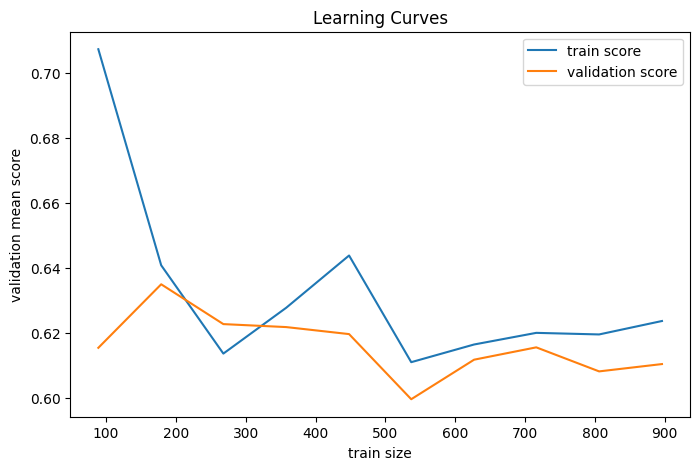


Evalution for german_credit_data.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62        62
           1       0.60      0.62      0.61        58

    accuracy                           0.62       120
   macro avg       0.62      0.62      0.62       120
weighted avg       0.62      0.62      0.62       120



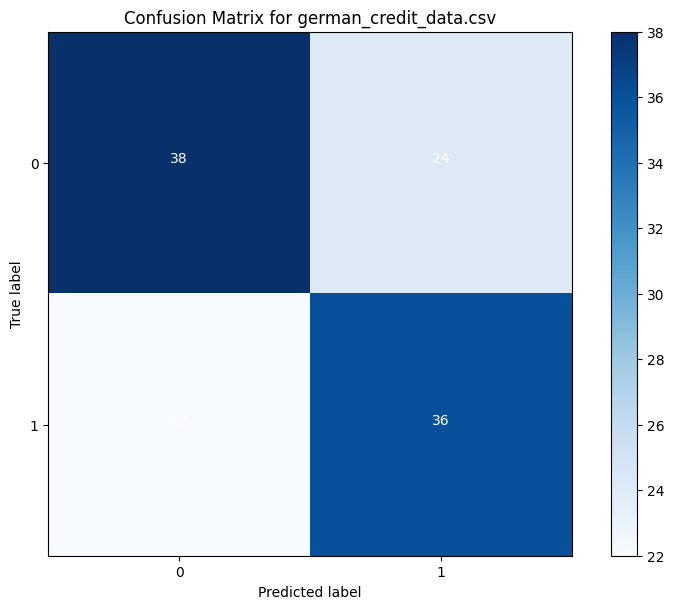

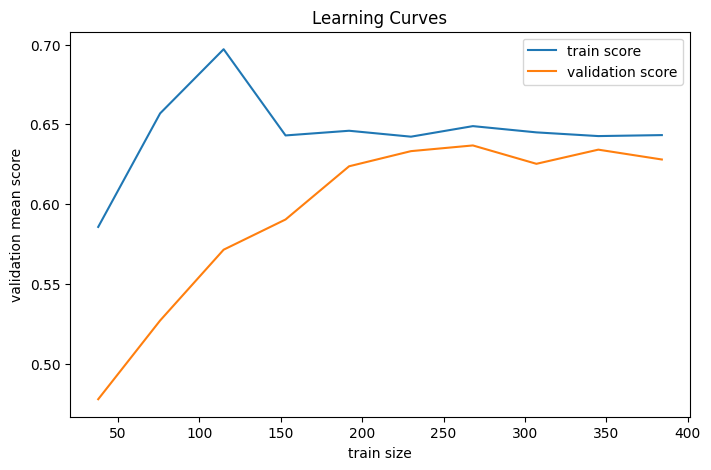


Evalution for CleanedOriginalDataset.csv using Oversampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64     32079
           1       0.64      0.67      0.65     32308

    accuracy                           0.65     64387
   macro avg       0.65      0.65      0.65     64387
weighted avg       0.65      0.65      0.65     64387



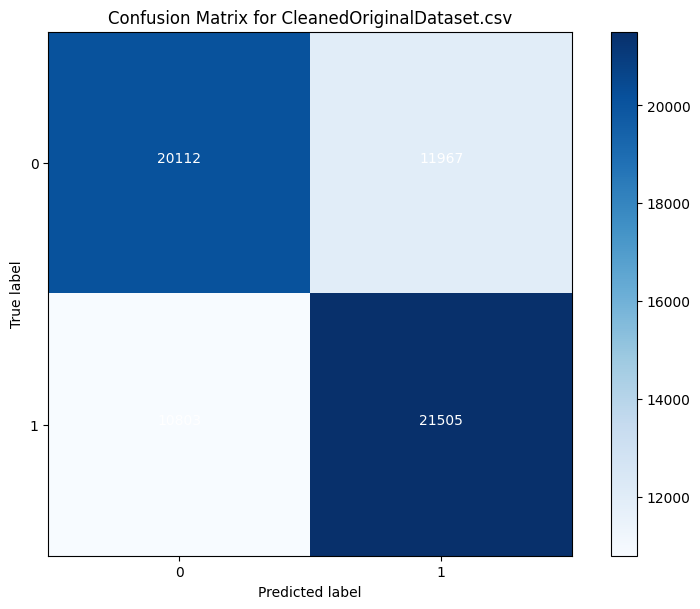

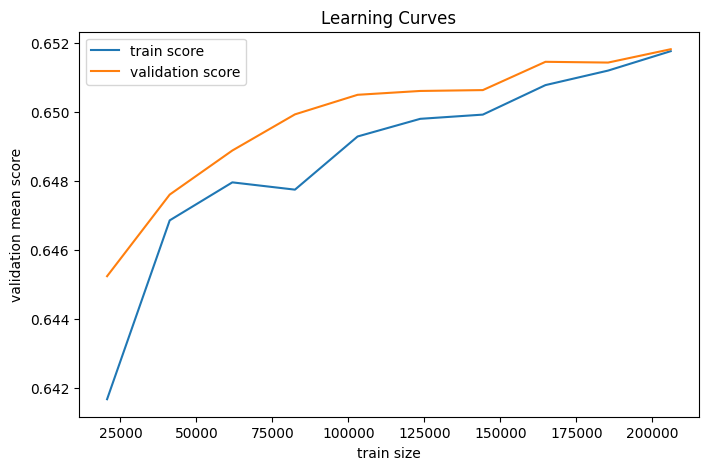


Evalution for CleanedOriginalDataset.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      3478
           1       0.65      0.67      0.66      3504

    accuracy                           0.65      6982
   macro avg       0.65      0.65      0.65      6982
weighted avg       0.65      0.65      0.65      6982



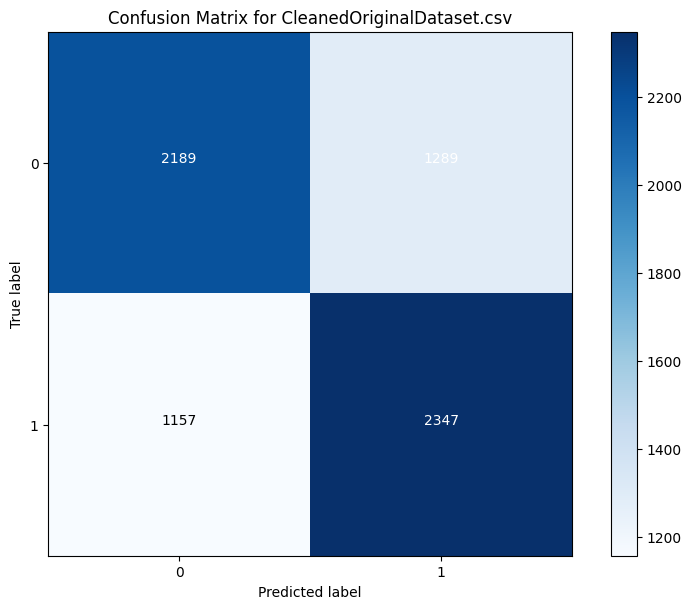

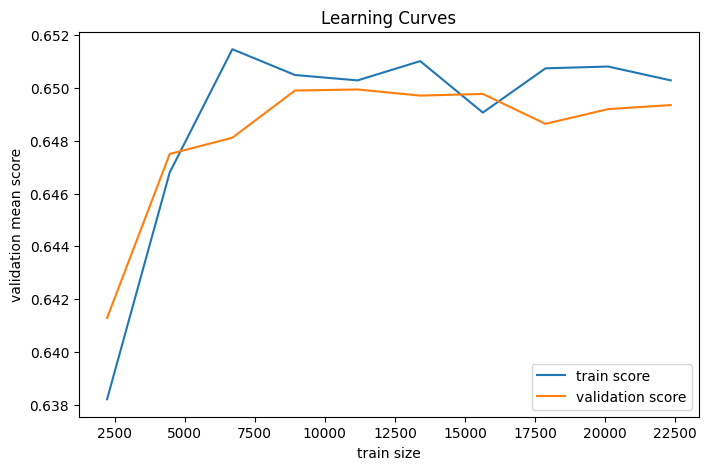


Evalution for merged_payment_customer_data.csv using Oversampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.52      0.57      1375
           1       0.59      0.70      0.64      1371

    accuracy                           0.61      2746
   macro avg       0.61      0.61      0.60      2746
weighted avg       0.61      0.61      0.60      2746



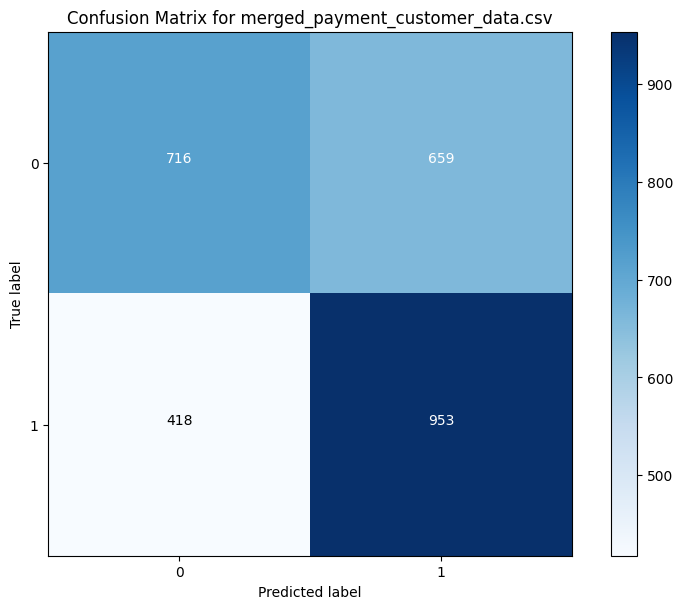

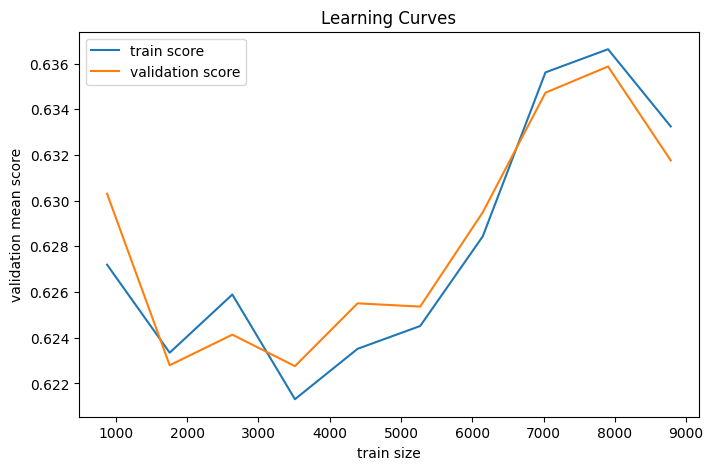


Evalution for merged_payment_customer_data.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       285
           1       0.59      0.65      0.62       270

    accuracy                           0.61       555
   macro avg       0.61      0.61      0.61       555
weighted avg       0.61      0.61      0.61       555



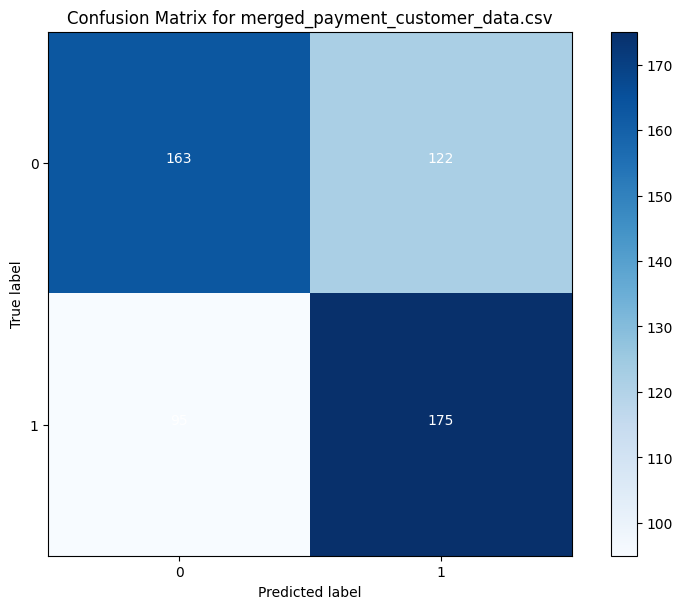

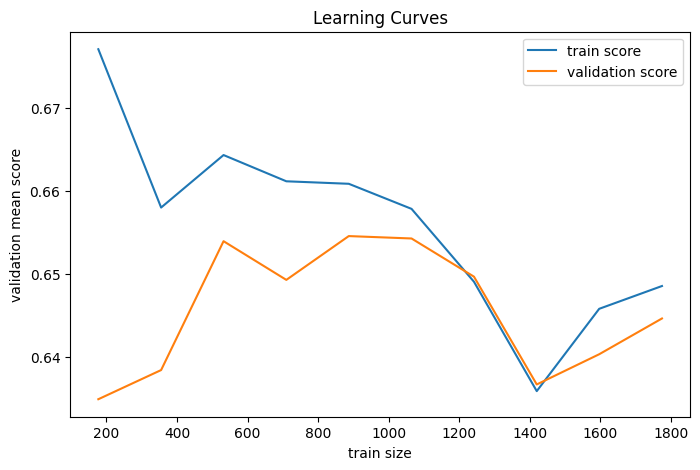

In [29]:
for dataset_name, dataset in new_datasets.items():
    X = dataset.drop(columns=['TARGET'])  # Assuming 'TARGET' is the name of the target column
    y = dataset['TARGET']
    
    # Apply oversampling
    X_over, y_over = oversample_data(X, y)
    
    # Apply undersampling
    X_resampled, y_resampled = undersample_data(X, y)
    
    models = {
        "Oversampled": (X_over, y_over),
        "Undersampled": (X_resampled, y_resampled)
    }

    for technique, (X_resampled, y_resampled) in models.items():
        modelLG3 = LogisticRegression(random_state=42)

        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
        
        modelLG3.fit(X_train, y_train)
        print(f"Evalution for {dataset_name} using {technique} :\n")
        # Evaluate and plot the model
        evaluate_model_and_plot(modelLG3, X_test, y_test, X_train=X_train, y_train=y_train, plot_learning_curve=True, dataset_name=dataset_name, model_name=f'Logistic Regression ({technique})')
        print()

# Decision Tree Model

## Decision Tree with cross validation and grid search with Oversampling and Undersampling

Shape after oversampling for german_credit_data.csv: (1400, 8)
Shape after undersampling for german_credit_data.csv: (600, 8)
Best parameters after oversampling for german_credit_data.csv: {'criterion': 'entropy', 'max_depth': 90, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy score after oversampling for german_credit_data.csv: 0.8095238095238095
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       149

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



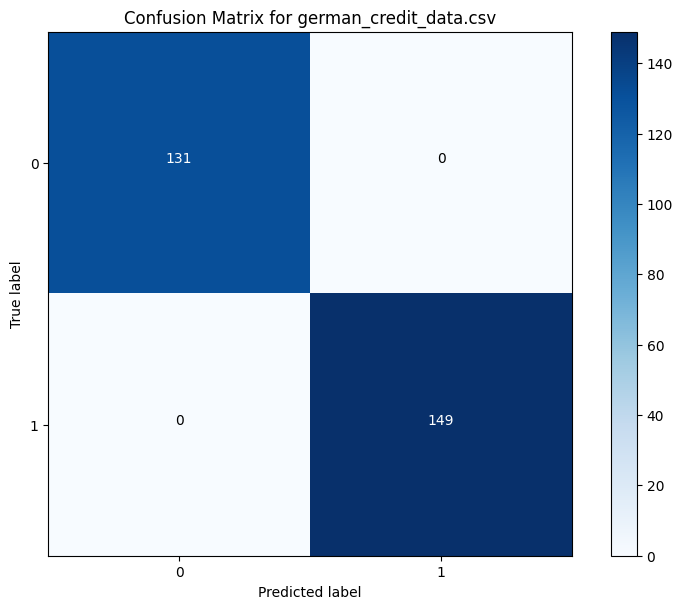

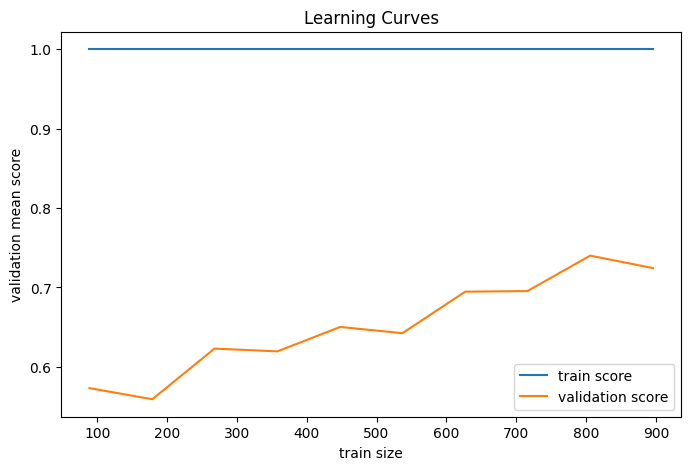

Best parameters after undersampling for german_credit_data.csv: {'criterion': 'gini', 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best accuracy score after undersampling for german_credit_data.csv: 0.5972222222222222
Evalution for german_credit_data.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        62
           1       0.96      0.74      0.83        58

    accuracy                           0.86       120
   macro avg       0.88      0.85      0.86       120
weighted avg       0.88      0.86      0.86       120



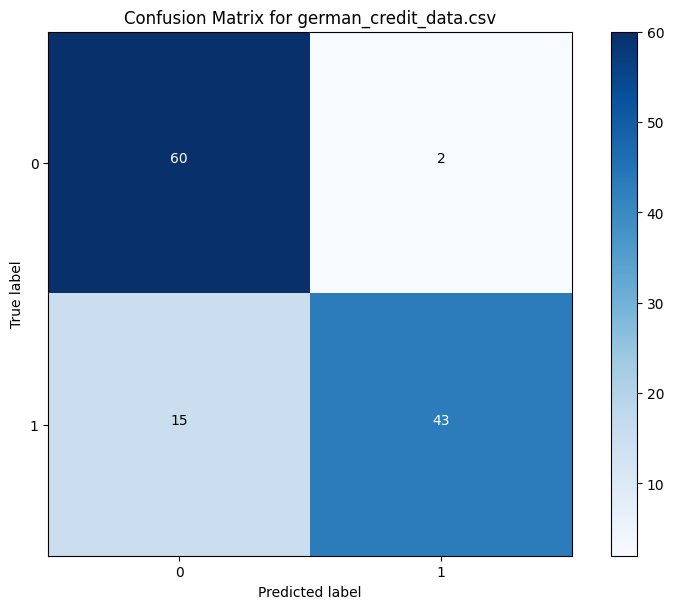

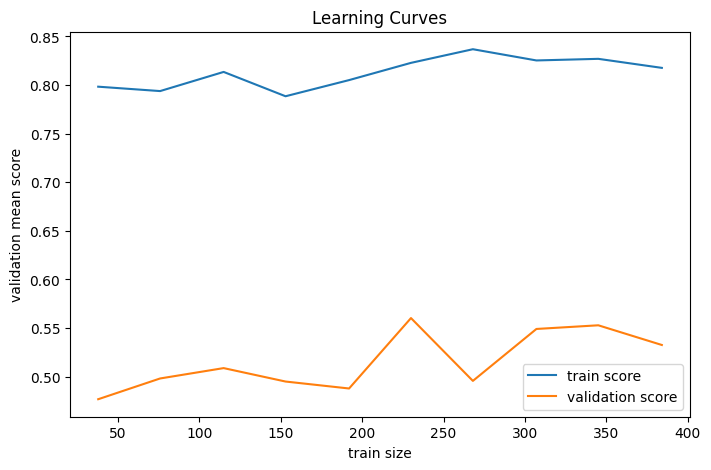


Shape after oversampling for CleanedOriginalDataset.csv: (321932, 8)
Shape after undersampling for CleanedOriginalDataset.csv: (34906, 8)
Best parameters after oversampling for CleanedOriginalDataset.csv: {'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy score after oversampling for CleanedOriginalDataset.csv: 0.9460662503083034
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32079
           1       1.00      1.00      1.00     32308

    accuracy                           1.00     64387
   macro avg       1.00      1.00      1.00     64387
weighted avg       1.00      1.00      1.00     64387



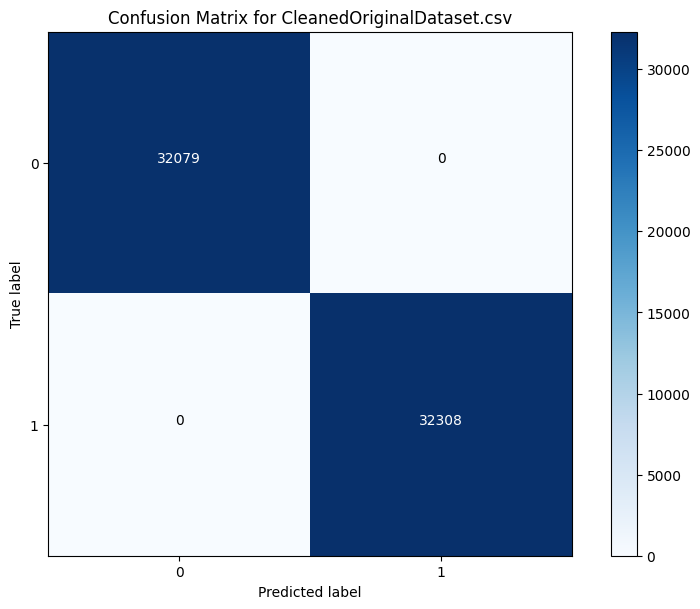

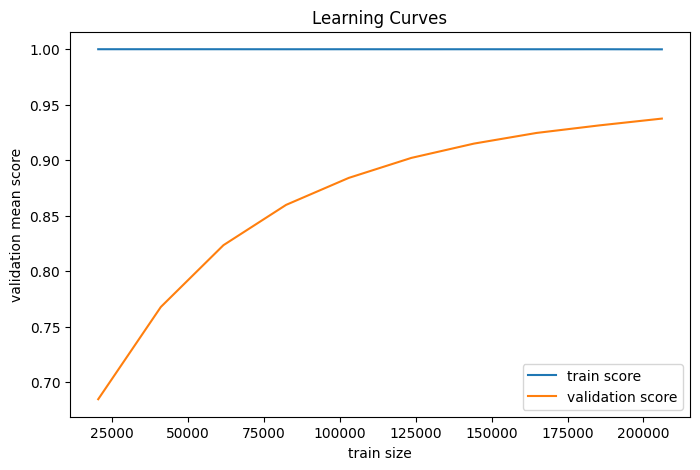

Best parameters after undersampling for CleanedOriginalDataset.csv: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best accuracy score after undersampling for CleanedOriginalDataset.csv: 0.6323172171446024
Evalution for CleanedOriginalDataset.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      3478
           1       0.68      0.69      0.69      3504

    accuracy                           0.68      6982
   macro avg       0.68      0.68      0.68      6982
weighted avg       0.68      0.68      0.68      6982



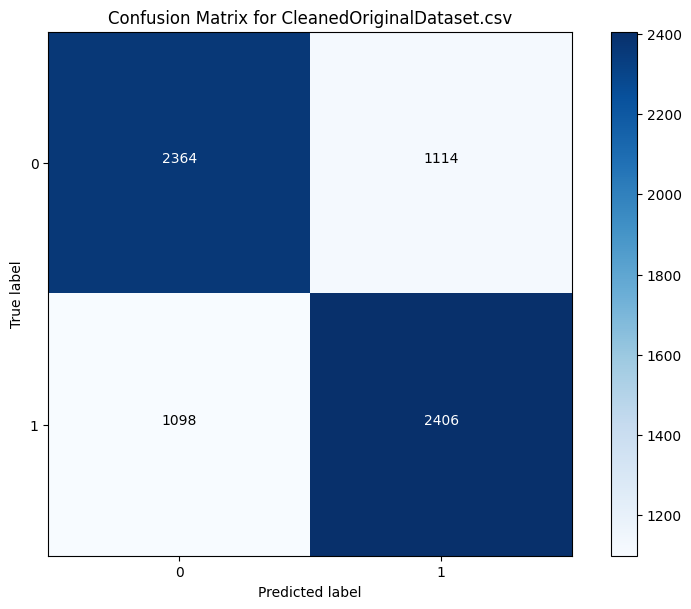

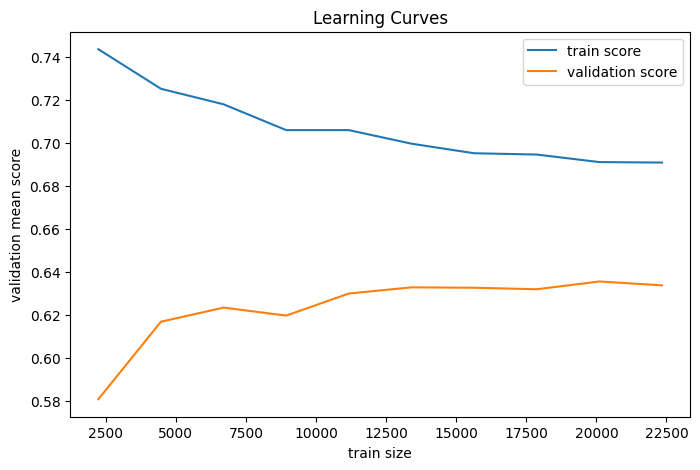


Shape after oversampling for merged_payment_customer_data.csv: (13726, 8)
Shape after undersampling for merged_payment_customer_data.csv: (2774, 8)
Best parameters after oversampling for merged_payment_customer_data.csv: {'criterion': 'gini', 'max_depth': 80, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy score after oversampling for merged_payment_customer_data.csv: 0.9979843906088935
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1375
           1       1.00      1.00      1.00      1371

    accuracy                           1.00      2746
   macro avg       1.00      1.00      1.00      2746
weighted avg       1.00      1.00      1.00      2746



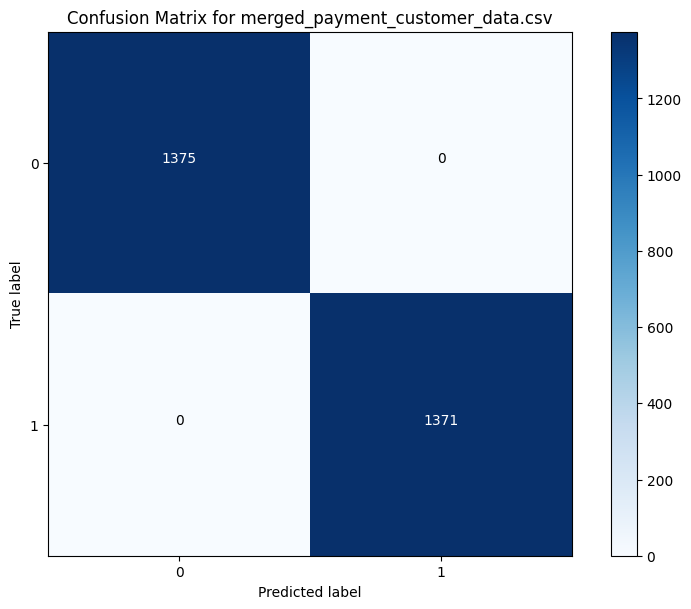

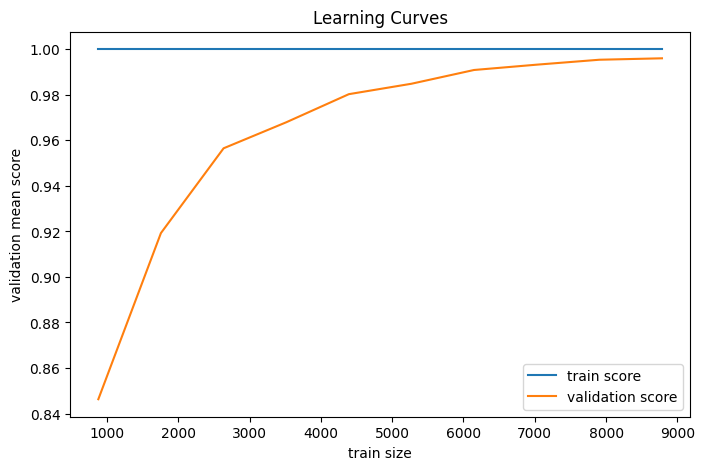

Best parameters after undersampling for merged_payment_customer_data.csv: {'criterion': 'gini', 'max_depth': 40, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy score after undersampling for merged_payment_customer_data.csv: 0.9477275831788468
Evalution for merged_payment_customer_data.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       270

    accuracy                           1.00       555
   macro avg       1.00      1.00      1.00       555
weighted avg       1.00      1.00      1.00       555



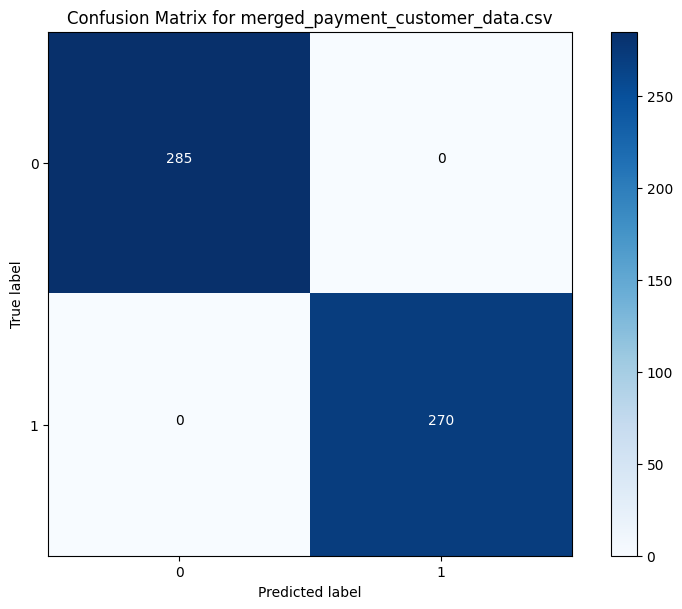

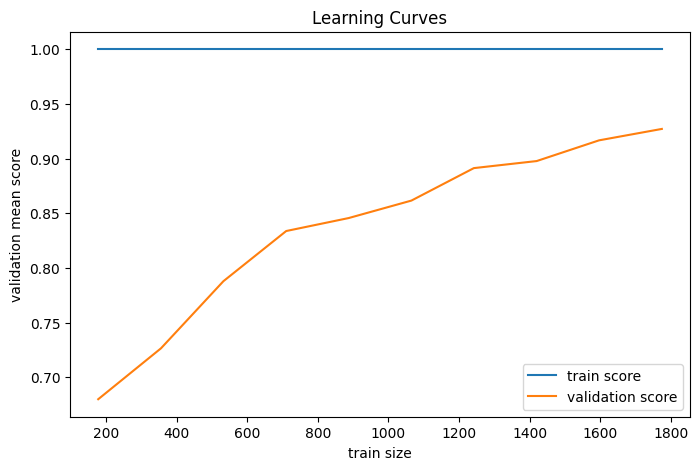

In [30]:
# Define parameters for Decision Tree
criterion = ['gini', 'entropy']
max_depth = [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt', 'log2', None]

# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

for dataset_name, dataset in new_datasets.items():
    X = dataset.drop(columns=['TARGET'])  # Assuming 'TARGET' is the name of the target column
    y = dataset['TARGET']

    # Apply oversampling
    X_resampled_over, y_resampled_over = oversample_data(X, y)
    print(f"Shape after oversampling for {dataset_name}: {X_resampled_over.shape}")

    # Apply undersampling
    X_resampled_under, y_resampled_under = undersample_data(X, y)
    print(f"Shape after undersampling for {dataset_name}: {X_resampled_under.shape}")

    # Create the Decision Tree model
    modelDT1 = DecisionTreeClassifier()

    # Create the parameter grid
    param_grid = {
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features
    }

    # Define grid search
    grid = GridSearchCV(estimator=modelDT1, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Perform grid search with oversampled dataset
    grid_result_over = grid.fit(X_resampled_over, y_resampled_over)

    # Summarize results
    print(f"Best parameters after oversampling for {dataset_name}: {grid_result_over.best_params_}")
    print(f"Best accuracy score after oversampling for {dataset_name}: {grid_result_over.best_score_}")

    # Apply the evaluate_model_and_plot function on the oversampled dataset
    X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_resampled_over, y_resampled_over, test_size=0.2, random_state=42)
    evaluate_model_and_plot(grid_result_over.best_estimator_, X_test_over, y_test_over, X_train=X_train_over, y_train=y_train_over, 
                            plot_learning_curve=True, dataset_name=dataset_name, model_name='Decision Tree (Oversampling)')

    # Perform grid search with undersampled dataset
    grid_result_under = grid.fit(X_resampled_under, y_resampled_under)

    # Summarize results
    print(f"Best parameters after undersampling for {dataset_name}: {grid_result_under.best_params_}")
    print(f"Best accuracy score after undersampling for {dataset_name}: {grid_result_under.best_score_}")

    # Apply the evaluate_model_and_plot function on the undersampled dataset
    X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_resampled_under, y_resampled_under, test_size=0.2, random_state=42)
    print(f"Evalution for {dataset_name} using {technique} :\n")

    evaluate_model_and_plot(grid_result_under.best_estimator_, X_test_under, y_test_under, X_train=X_train_under, y_train=y_train_under, 
                            plot_learning_curve=True, dataset_name=dataset_name, model_name='Decision Tree (Undersampling)')
    print()

## Normal Decision Tree

Evalution for german_credit_data.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.51      0.44        59
           1       0.76      0.67      0.71       141

    accuracy                           0.62       200
   macro avg       0.58      0.59      0.58       200
weighted avg       0.65      0.62      0.63       200



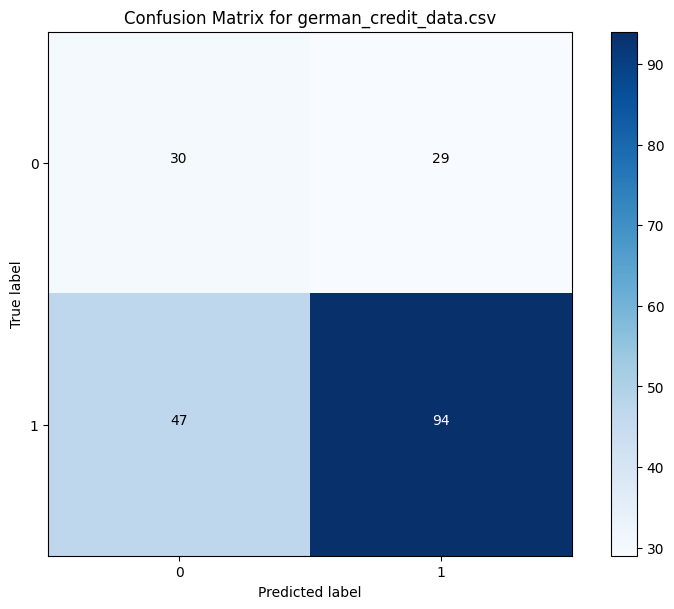

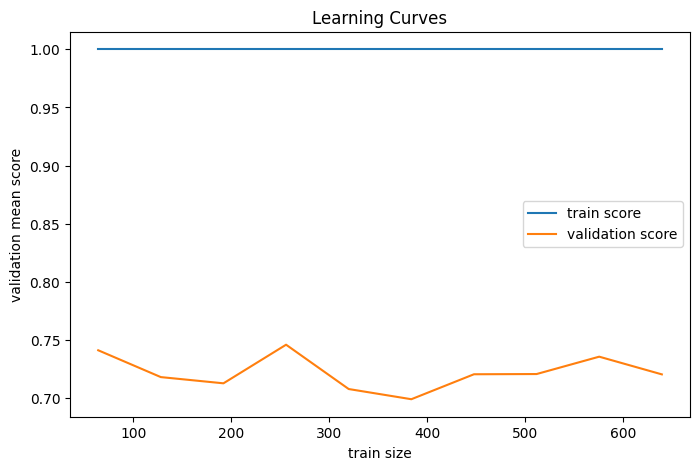


Evalution for CleanedOriginalDataset.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     32199
           1       0.16      0.18      0.17      3485

    accuracy                           0.83     35684
   macro avg       0.54      0.54      0.54     35684
weighted avg       0.84      0.83      0.83     35684



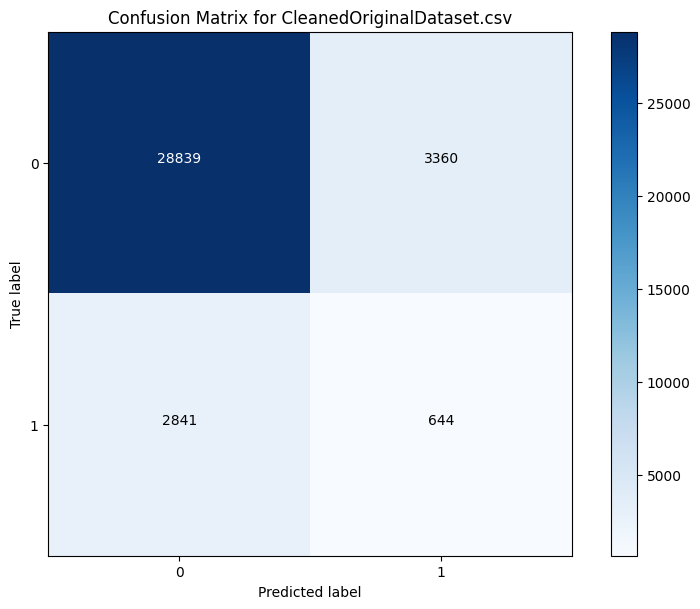

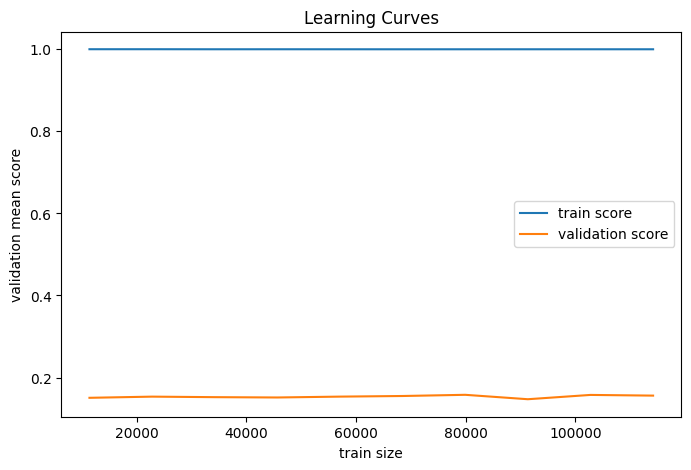


Evalution for merged_payment_customer_data.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1384
           1       0.97      0.98      0.98       266

    accuracy                           0.99      1650
   macro avg       0.98      0.99      0.99      1650
weighted avg       0.99      0.99      0.99      1650



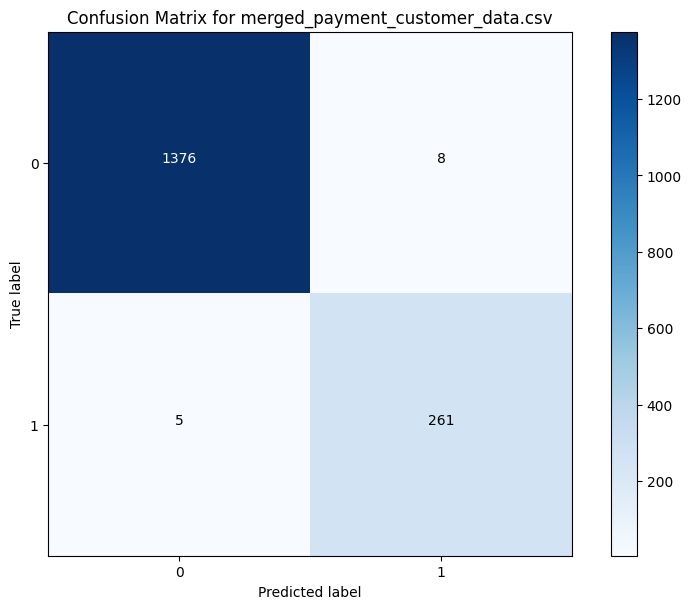

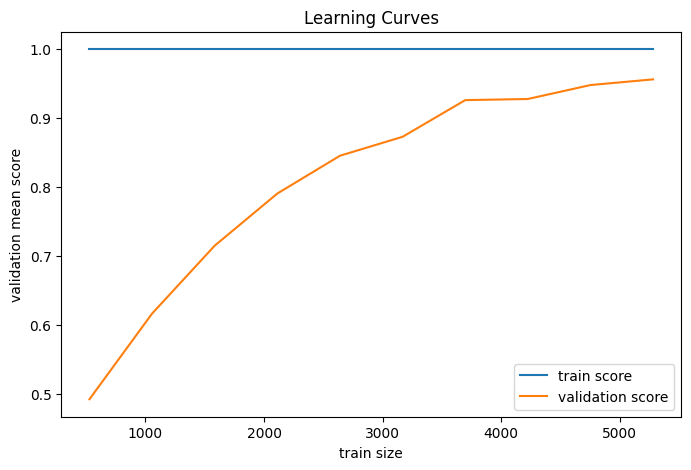

In [31]:
for dataset_name, dataset in new_datasets.items():
    X = dataset.drop(columns=['TARGET'])  
    y = dataset['TARGET']
    
    modelDT2 = DecisionTreeClassifier(random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    modelDT2.fit(X_train, y_train)
    
    print(f"Evalution for {dataset_name} using {technique} :\n")
    # Evaluate and plot the model
    evaluate_model_and_plot(modelDT2, X_test, y_test, X_train=X_train, y_train=y_train, plot_learning_curve=True, dataset_name=dataset_name, model_name='Decision Tree')
    print()

## Normal Decision Tree with Oversampling and Undersampling

Evalution for german_credit_data.csv using Oversampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       131
           1       0.90      0.70      0.79       149

    accuracy                           0.80       280
   macro avg       0.81      0.81      0.80       280
weighted avg       0.82      0.80      0.80       280



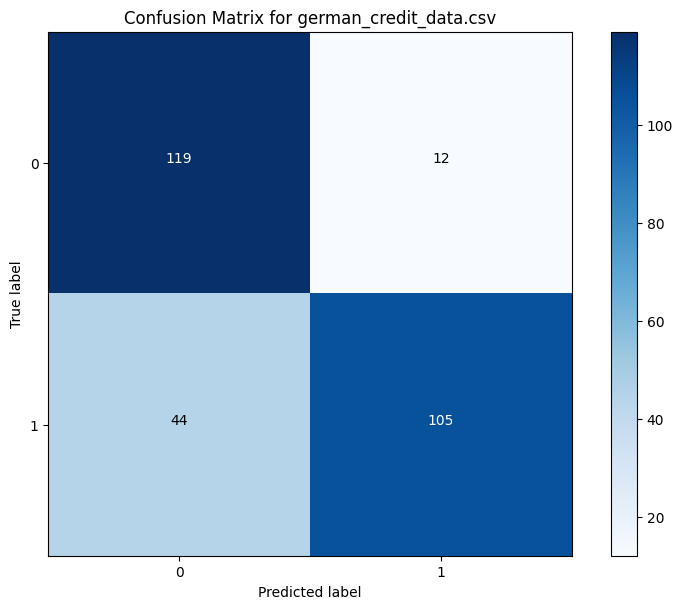

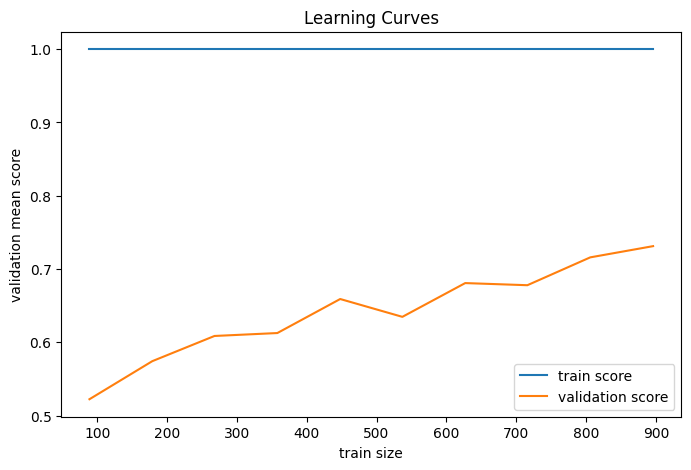


Evalution for german_credit_data.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.42      0.45        62
           1       0.45      0.52      0.48        58

    accuracy                           0.47       120
   macro avg       0.47      0.47      0.47       120
weighted avg       0.47      0.47      0.47       120



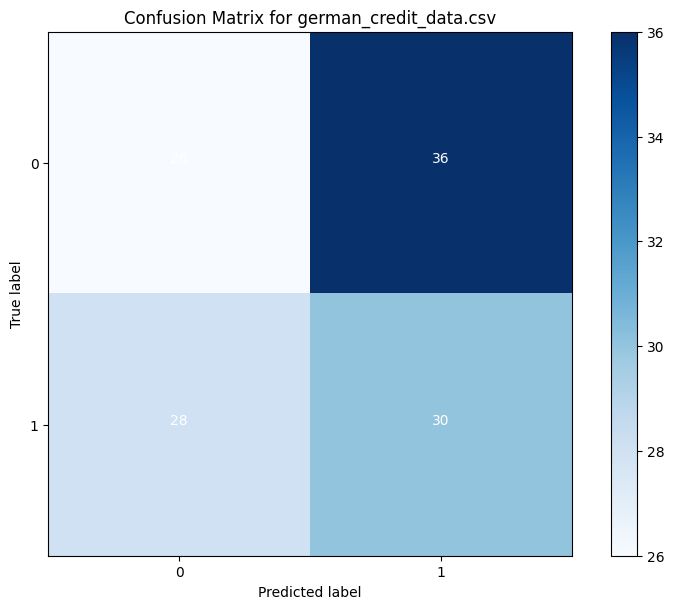

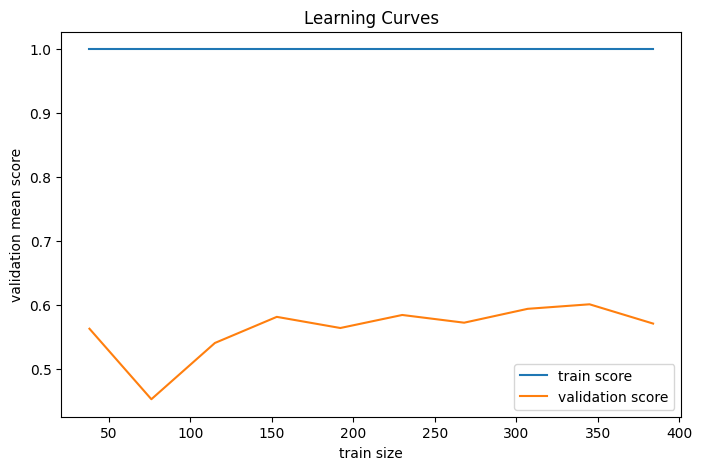


Evalution for CleanedOriginalDataset.csv using Oversampled :

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     32079
           1       0.90      1.00      0.95     32308

    accuracy                           0.94     64387
   macro avg       0.95      0.94      0.94     64387
weighted avg       0.95      0.94      0.94     64387



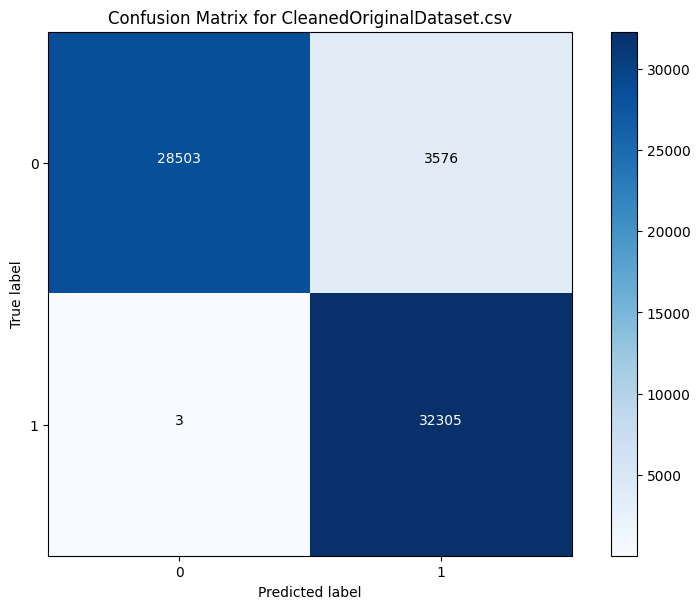

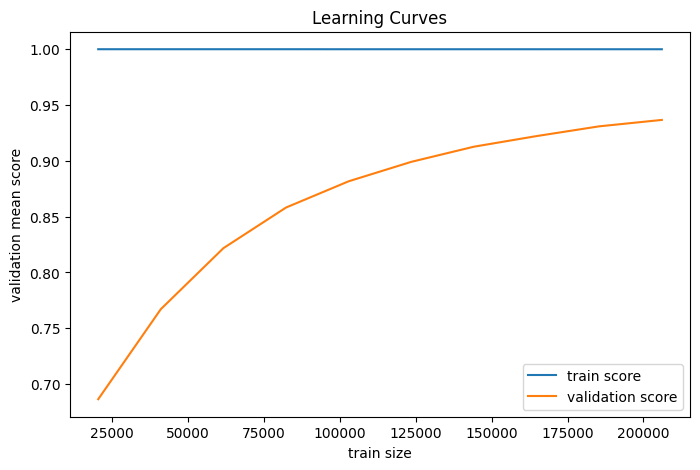


Evalution for CleanedOriginalDataset.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      3478
           1       0.57      0.56      0.57      3504

    accuracy                           0.57      6982
   macro avg       0.57      0.57      0.57      6982
weighted avg       0.57      0.57      0.57      6982



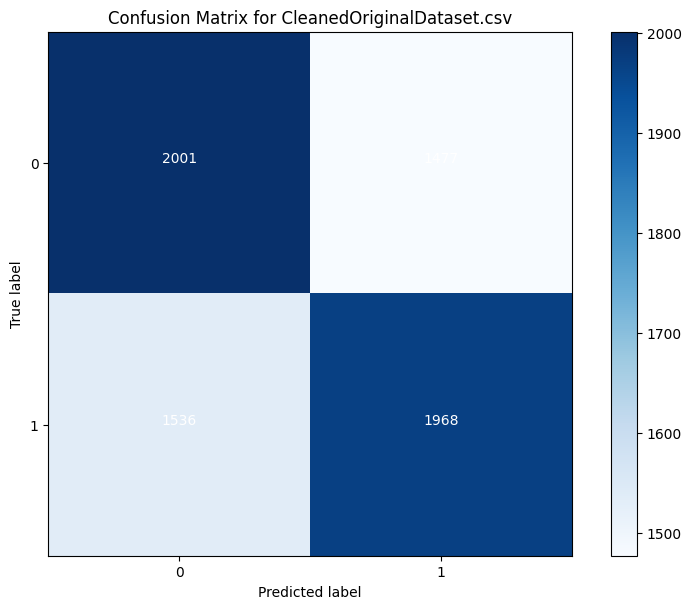

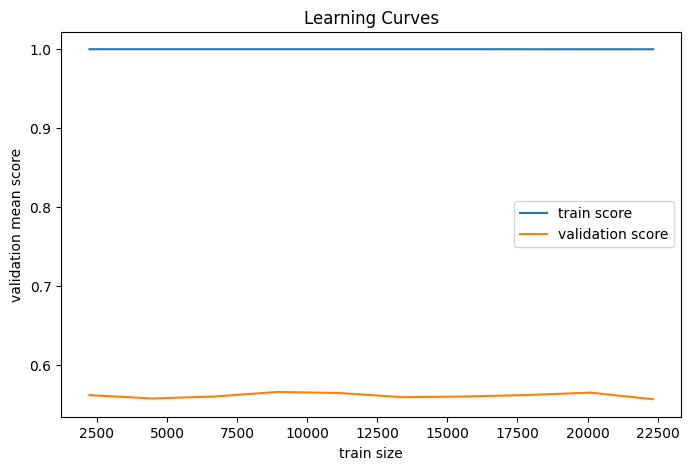


Evalution for merged_payment_customer_data.csv using Oversampled :

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1375
           1       1.00      1.00      1.00      1371

    accuracy                           1.00      2746
   macro avg       1.00      1.00      1.00      2746
weighted avg       1.00      1.00      1.00      2746



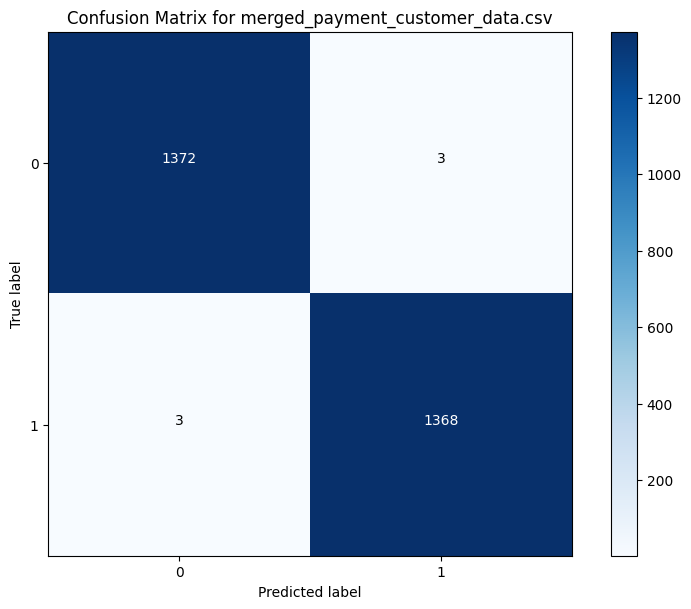

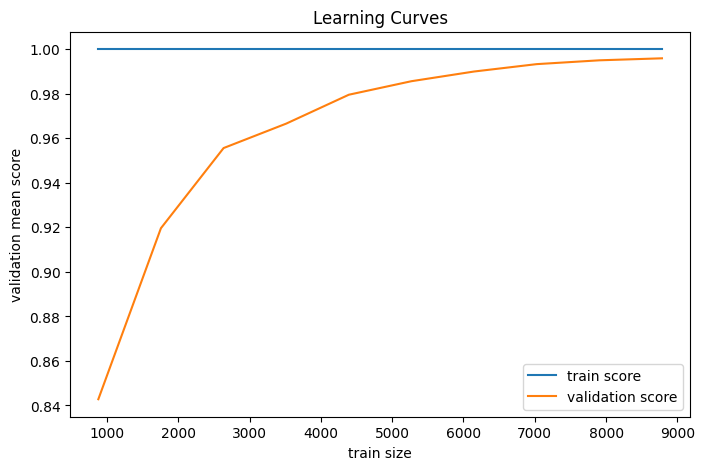


Evalution for merged_payment_customer_data.csv using Undersampled :

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       285
           1       0.89      0.97      0.93       270

    accuracy                           0.93       555
   macro avg       0.93      0.93      0.93       555
weighted avg       0.93      0.93      0.93       555



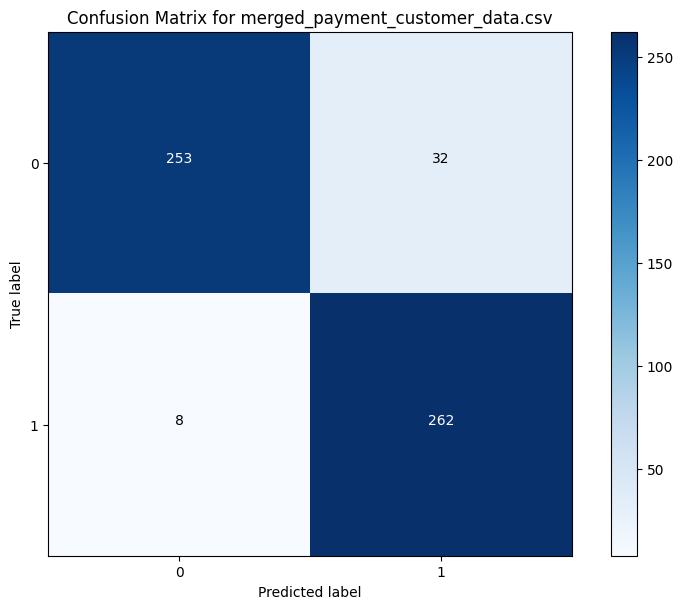

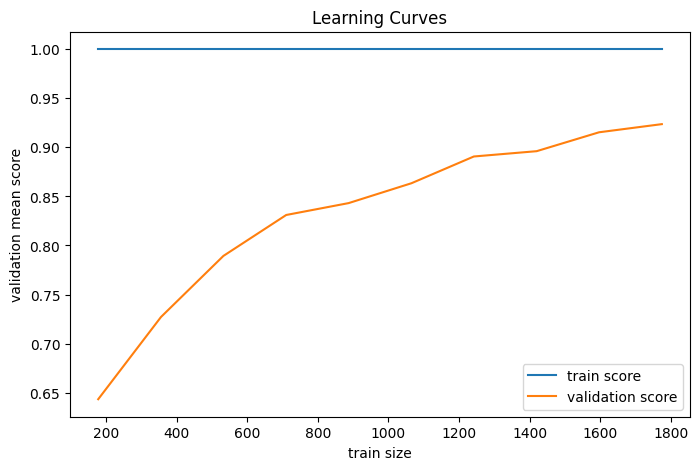

In [32]:
for dataset_name, dataset in new_datasets.items():
    X = dataset.drop(columns=['TARGET']) 
    y = dataset['TARGET']
    
    # Apply oversampling
    X_over, y_over = oversample_data(X, y)
    
    # Apply undersampling
    X_resampled, y_resampled = undersample_data(X, y)
    
    modelDT3 = DecisionTreeClassifier(random_state=42)
    models = {
        "Oversampled": (X_over, y_over),
        "Undersampled": (X_resampled, y_resampled)
    }

    for technique, (X_resampled, y_resampled) in models.items():

        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
        
        modelDT3.fit(X_train, y_train)
        print(f"Evalution for {dataset_name} using {technique} :\n")
        # Evaluate and plot the model
        evaluate_model_and_plot(modelDT3, X_test, y_test, X_train=X_train, y_train=y_train, plot_learning_curve=True, dataset_name=dataset_name, model_name=f'Decision Tree ({technique})')
        print()